# Trabalho de Conclusão de Curso - Ciência de Dados Aplicada para Manutenção Preditiva
---
## Contexto

Projeto apresentado no Trabalho de Conclusão de Curso (TCC) de [Eduardo Acrani Ruivo](https://www.linkedin.com/in/eduardo-acrani-ruivo-0219041b7/) no curso de Engenharia de Controle e Automação da Universidade Feredal de Uberlândia (UFU), sob orientação do professor Dr. Josué Silva de Morais.

## Introdução 

Neste projeto foi analisado dados sintéticos de máquinas para manutenção preditiva, uma vez que coletar dados reais é algo muito difícil e é ainda mais difícil encontrar uma empresa que divulgue tais dados. Com isso, foram utilizados os dados presentes no conjunto de dados nomeado de "Machine Predictive Maintenance Classification" que, refletem dados reais encontrados nas indústrias para manutenção preditiva.

Os dados foram analisados com os seguintes intuitos:
- Identificar a separabilidade nos dados dos equipamentos que sofreram falha dos que não sofreram;
- Identificar se alguma variável tem uma correlação direta com algum dos tipos de falha;
- Criar modelos para tentar prever quando o equipamento falhará e identificar qual tipo de falha, na expectativa de ajudar os setores de manutenção com seus planejamentos e prevenir quaisquer falhas indesejadas;

Após os dados serem analisados e passarem pelas devidas modificações, foram utilizados para treinar modelos de regressão logística, classificação e Ensemble da biblioteca [Scikit-Learn](https://scikit-learn.org/stable/).

Nota: Como os dataset tem um desbalanço de 96,52%-3,48% no Target, as expectativas devem ser reduzidas para o resultado obtido.

## Dataset

O dataset utilizado foi extraído do [Kaggle](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification/data). O dataset possui 10000 registros e 10 colunas, sendo:

* **UDI**: Identificador único na faixa de 1 até 10000

* **Product ID** - Consistindo em uma letra, sendo L para baixa (60% de todos os produtos), M para média (30%) e H para alta (10%) como variantes de qualidade do produto e um número de série específico da variante.

* **Type** - Consistindo em uma letra, sendo L para baixa (60% de todos os produtos), M para média (30%) e H para alta (10%) como variantes de qualidade do produto.

* **Air temperature [K]** - Temperatudra do Ar. Gerado usando um processo de passo aleatório e posteriormente normalizado para um desvio padrão de 2K em torno de 300K

* **Process temperature [K]** - Temperatudra do Processo. Gerado usando um processo de passo aleatório e posteriormente normalizado para um desvio padrão de 1K, adicionado à temperatura do ar mais 10K.

* **Rotational speed [rpm]** - Velocidade Rotacional. Calculado a partir de uma potência de 2860 W, sobreposta a um ruído normalmente distribuído.

* **Torque [Nm]** - Os valores de torque são normalmente distribuídos em torno de 40 Nm com Ïƒ = 10 Nm e sem valores negativos.

* **Tool wear [min]** - Desgaste do Equipamento. As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta usada no processo.

* **Target** - Valor alvo. Indica se o equipamento falou ou não alguma vez.

* **Failure Type** - Tipo de falha. Indica qual tipo de falha o equipamento teve, caso teve. São eles Heat Dissipation Failure (falha na dissipação de calor), Power Failure (falha na energia), Overstrain Failure (falha por sobretensão), Tool Wear Failure (falha por desgate do equipamento) e Random Failures (falha aleatória).

As informações acima foram retiradas da descrição dada pelo usuário que forneceu o conjunto de dados e foi traduzida e ajustada para melhor entendimento na língua portuguesa.

### Importando Bibliotecas

In [1]:
#Análises
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Processamento e Auxiliares
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline

#Métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, recall_score, f1_score, accuracy_score, precision_score

import warnings
warnings.simplefilter(action='ignore', category=Warning)

### Importando o Cojunto de Dados

Foi importado a coluna **UDI** como índice para acabar com a redundância de ter coluna numérica sequencial de 0 até 9.999 e uma coluna numérica sequencial de 1 até 10.000 e, assim, facilitar o entendimento para pessoas que não são da área.

In [2]:
df = pd.read_csv('predictive_maintenance.csv', index_col = "UDI")
df

Product ID Type  Air temperature [K]  Process temperature [K]  \
UDI                                                                   
1         M14860    M                298.1                    308.6   
2         L47181    L                298.2                    308.7   
3         L47182    L                298.1                    308.5   
4         L47183    L                298.2                    308.6   
5         L47184    L                298.2                    308.7   
...          ...  ...                  ...                      ...   
9996      M24855    M                298.8                    308.4   
9997      H39410    H                298.9                    308.4   
9998      M24857    M                299.0                    308.6   
9999      H39412    H                299.0                    308.7   
10000     M24859    M                299.0                    308.7   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
UDI                                                                   
1                        1551         42.8                0       0   
2                        1408         46.3                3       0   
3                        1498         49.4                5       0   
4                        1433         39.5                7       0   
5                        1408         40.0                9       0   
...                       ...          ...              ...     ...   
9996                     1604         29.5               14       0   
9997                     1632         31.8               17       0   
9998                     1645         33.4               22       0   
9999                     1408         48.5               25       0   
10000                    1500         40.2               30       0   

      Failure Type  
UDI                 
1       No Failure  
2       No Failure  
3       No Failure  
4       No Failure  
5       No Failure  
...            ...  
9996    No Failure  
9997    No Failure  
9998    No Failure  
9999    No Failure  
10000   No Failure  

[10000 rows x 9 columns]

### Análise inicial dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 781.2+ KB


Como transformamos a coluna **UDI** no índice, nosso conjunto de dados ficou com 9 colunas de dados. Podemos observar que não existe nenhuma dado nulo sem nenhuma das colunas. Conseguimos identificar também quais os tipo de dados cada coluna possui.

In [4]:
df.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]        Target  
count  10000.000000     10000.000000  10000.000000  
mean      39.986910       107.951000      0.033900  
std        9.968934        63.654147      0.180981  
min        3.800000         0.000000      0.000000  
25%       33.200000        53.000000      0.000000  
50%       40.100000       108.000000      0.000000  
75%       46.800000       162.000000      0.000000  
max       76.600000       253.000000      1.000000

Utilizando da função describe, podemos observar qual a variação dos valores mínimos e máximos de cada coluna. Vemos também suas médias, desvio padrão e os valores dos seus quartis.

In [5]:
for column in ["Type", "Target","Failure Type"]:
    print(f"Coluna: {column}")
    print(df[column].value_counts(normalize = True) * 100)
    print(f'\n{"="*80}\n')

Coluna: Type
L    60.00
M    29.97
H    10.03
Name: Type, dtype: float64


Coluna: Target
0    96.61
1     3.39
Name: Target, dtype: float64


Coluna: Failure Type
No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: Failure Type, dtype: float64




Analisando a distribuição em porcentagem das variáveis "Categóricas" podemos notar uma inconsistência, pois, ao analisar-mos as coluna **Target**, percebemos que existem 96.61% dos dados que são considerados sem falhas e, quando olhamos a coluna **Failure Types**, o a quantidade de valores sem falhas é de 96.52%. Sendo assim necessário investigação.

In [6]:
#Distribuição dos dados que possuem o Target = 1 (Equipamentos que apresentam falhas)
for column in ["Type", "Failure Type"]:
    print(f"Coluna: {column}")
    print(df[df["Target"] == 1][column].value_counts())
    print(f'\n{"="*80}\n')

Coluna: Type
L    235
M     83
H     21
Name: Type, dtype: int64


Coluna: Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64




In [7]:
#Distribuição dos dados que possuem o Target = 0 (Equipamentos que não apresentam falhas)
for column in ["Type", "Failure Type"]:
    print(f"Coluna: {column}")
    print(df[df["Target"] == 0][column].value_counts())
    print(f'\n{"="*80}\n')

Coluna: Type
L    5765
M    2914
H     982
Name: Type, dtype: int64


Coluna: Failure Type
No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64




Observando acima, podemos notar que existem 9 dados **No Failure** e 18 dados **Random Failures** com o valor da coluna **Target** invertido e devem ser arrumados.

In [8]:
#Atribuindo o valores corretos de Target.
df.loc[df['Failure Type'] == 'Random Failures', 'Target'] = 1
df.loc[df['Failure Type'] == 'No Failure', 'Target'] = 0

In [9]:
for column in ["Type", "Failure Type"]:
    print(f"Coluna: {column}")
    print(df[df["Target"] == 1][column].value_counts())
    print(f'\n{"="*80}\n')

Coluna: Type
L    243
M     81
H     24
Name: Type, dtype: int64


Coluna: Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Random Failures              18
Name: Failure Type, dtype: int64




In [10]:
for column in ["Type", "Failure Type"]:
    print(f"Coluna: {column}")
    print(df[df["Target"] == 0][column].value_counts())
    print(f'\n{"="*80}\n')

Coluna: Type
L    5757
M    2916
H     979
Name: Type, dtype: int64


Coluna: Failure Type
No Failure    9652
Name: Failure Type, dtype: int64




In [11]:
for column in ["Type", "Target", "Failure Type"]:
    print(f"Coluna: {column}")
    print(df[column].value_counts(normalize=True) * 100)
    print(f'\n{"="*80}\n')

Coluna: Type
L    60.00
M    29.97
H    10.03
Name: Type, dtype: float64


Coluna: Target
0    96.52
1     3.48
Name: Target, dtype: float64


Coluna: Failure Type
No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: Failure Type, dtype: float64




Reutilizando dos mesmo códigos após as atribuições, podemos conferir que, de fato, os dados estão corretos agora.

In [12]:
df[df.duplicated(['Product ID'], keep=False)].sort_values(by='Product ID')

Empty DataFrame
Columns: [Product ID, Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min], Target, Failure Type]
Index: []

Acima podemos notar que não existe nenhum valor de **Product ID** repetido, sendo assim, temos 10.000 equipamentos diferentes, nenhum equipamento analisado mais de uma vez e nenhum dado redundante que possa ser removido. Assim, podemos remover essa coluna de nossa análise, pois ela não vai interferir em nenhum de nossos resultados.

In [13]:
#Removendo a coluna Product ID
df.drop(df.columns[:1],axis=1,inplace=True)
df.head()

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                      
1      M                298.1                    308.6   
2      L                298.2                    308.7   
3      L                298.1                    308.5   
4      L                298.2                    308.6   
5      L                298.2                    308.7   

     Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
UDI                                                                             
1                      1551         42.8                0       0   No Failure  
2                      1408         46.3                3       0   No Failure  
3                      1498         49.4                5       0   No Failure  
4                      1433         39.5                7       0   No Failure  
5                      1408         40.0                9       0   No Failure

# Análise de Valores Discrepantes (Outliers)

### Visualizando distribuições com histogramas

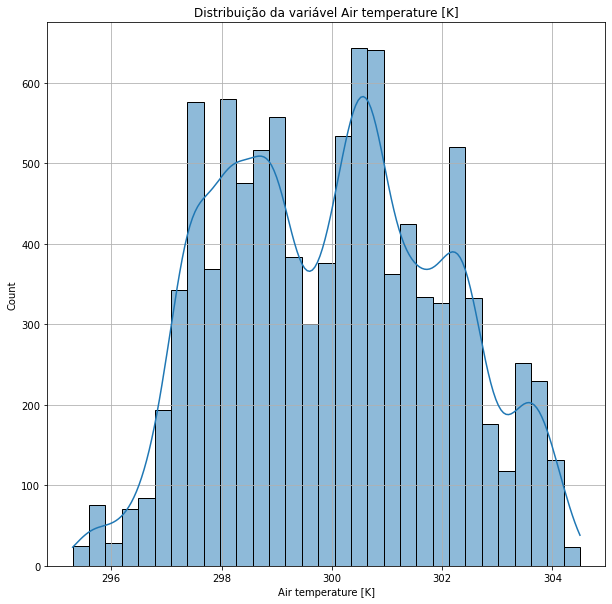

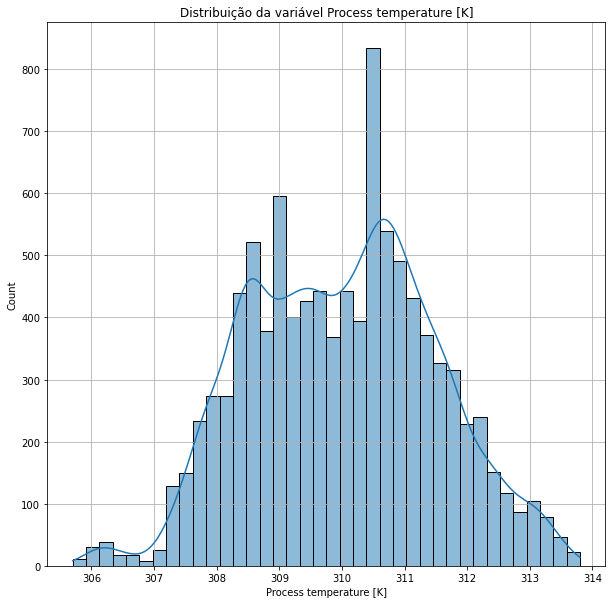

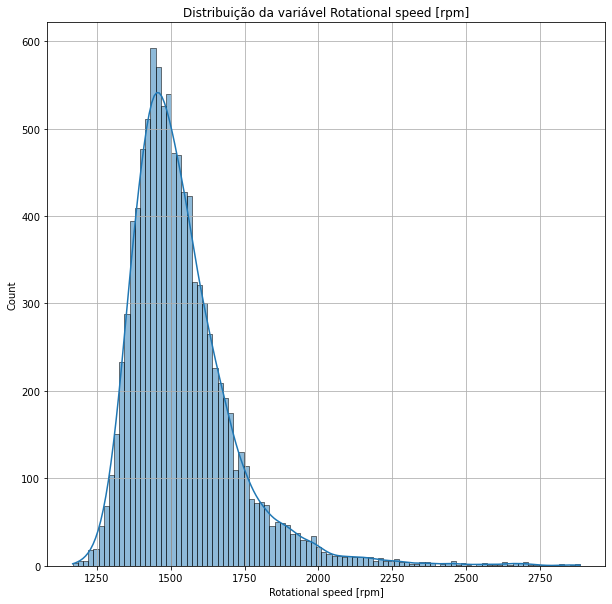

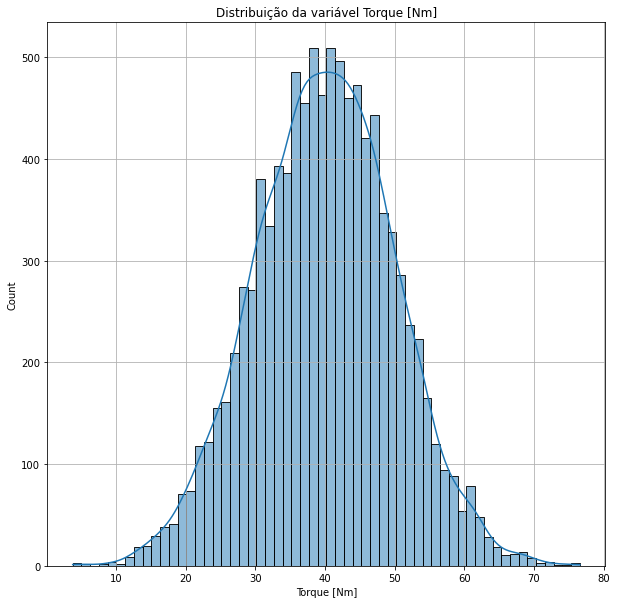

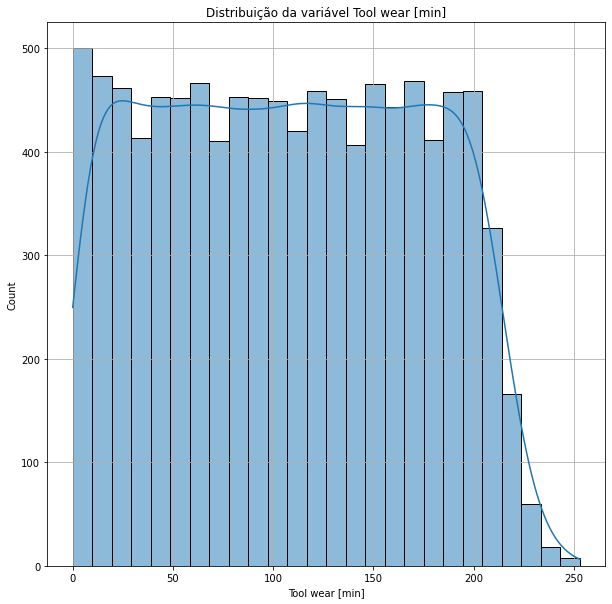

In [14]:
for col in df.columns[1:6]:
    plt.figure(figsize=(10,10))
    sns.histplot(data=df, x=col, kde=True).set_title(f"Distribuição da variável {col}")
    plt.grid()
    plt.show()

Analisando os gráficos, podemos ver que somente o **Torque** segue uma curva normal e o **Rotational Speed** aprensenta o padrão de uma curva normal, porém assimétrica à direita.

### Método de Tukey (Boxplot / Diagrama de Caixa)

O método de Tukey permite visualizar rapidamente a distribuição de valores em um conjunto de dados e ver onde estão localizadas as cinco estatísticas de resumo numéricos. Com ele, é possível fazer as visualizações gráficas que são os Diagramas de Caixa (Boxplot).

In [15]:
#Calculando o a Amplitude Interquartil(IQR) para poder calcular os limites superiores e inferiores.
df_desc = df.describe()
df_desc.loc['IQR'] = df_desc.loc['75%'] - df_desc.loc['25%']
df_desc.loc['Limite superior'] = df_desc.loc['75%'] + 1.5*df_desc.loc['IQR']
df_desc.loc['Limite inferior'] = df_desc.loc['25%'] - 1.5*df_desc.loc['IQR']
df_desc

Air temperature [K]  Process temperature [K]  \
count                   10000.000000             10000.000000   
mean                      300.004930               310.005560   
std                         2.000259                 1.483734   
min                       295.300000               305.700000   
25%                       298.300000               308.800000   
50%                       300.100000               310.100000   
75%                       301.500000               311.100000   
max                       304.500000               313.800000   
IQR                         3.200000                 2.300000   
Limite superior           306.300000               314.550000   
Limite inferior           293.500000               305.350000   

                 Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  \
count                      10000.000000  10000.000000     10000.000000   
mean                        1538.776100     39.986910       107.951000   
std                          179.284096      9.968934        63.654147   
min                         1168.000000      3.800000         0.000000   
25%                         1423.000000     33.200000        53.000000   
50%                         1503.000000     40.100000       108.000000   
75%                         1612.000000     46.800000       162.000000   
max                         2886.000000     76.600000       253.000000   
IQR                          189.000000     13.600000       109.000000   
Limite superior             1895.500000     67.200000       325.500000   
Limite inferior             1139.500000     12.800000      -110.500000   

                       Target  
count            10000.000000  
mean                 0.034800  
std                  0.183282  
min                  0.000000  
25%                  0.000000  
50%                  0.000000  
75%                  0.000000  
max                  1.000000  
IQR                  0.000000  
Limite superior      0.000000  
Limite inferior      0.000000

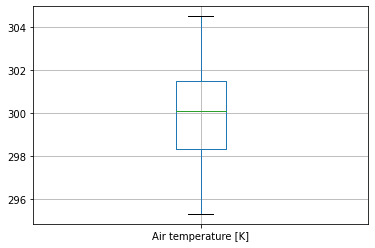

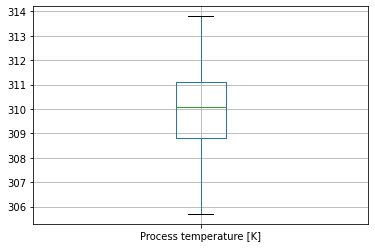

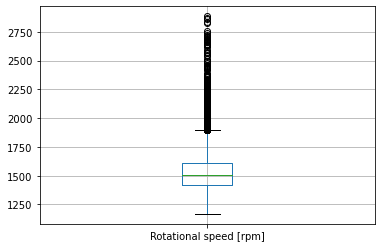

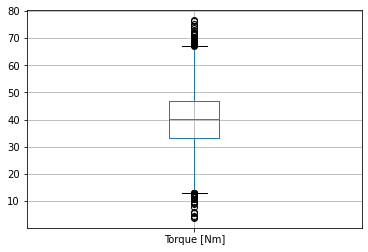

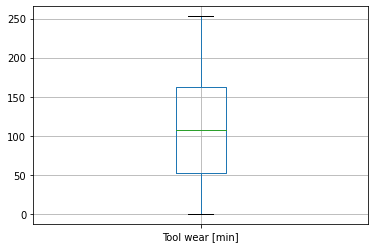

In [16]:
#Utilizando de funções prontas para facilitar nosso trabalho na criação de Boxplots
for col in df.columns[1:6]:
    plt.figure()
    df.boxplot([col])

Após a análise, podemos reparar que somente as variáveis **Rotational Speed** e **Torque** possuem Outliers. Sendo assim, devemos olhar quantos são e quais dados que compõem esses outliers para decidir se é possível descartar esses dados para facilitar a predição dos modelos.

In [17]:
print(f'Quantidade de outliers da Colunas Rotational Speed: {len(df[df["Rotational speed [rpm]"] > 1895.500000])}')
print('\nDistruibuição dos outliers em relação ao seu tipo de falha:')
print(df[df["Rotational speed [rpm]"] > 1895.500000]['Failure Type'].value_counts())

Quantidade de outliers da Colunas Rotational Speed: 418

Distruibuição dos outliers em relação ao seu tipo de falha:
No Failure           383
Power Failure         31
Tool Wear Failure      4
Name: Failure Type, dtype: int64


In [18]:
print(f'Quantidade de outliers da Colunas Rotational Speed: {len(df[df["Torque [Nm]"] < 12.800000]) + len(df[df["Torque [Nm]"] > 67.200000])}')
print('\nDistruibuição dos outliers inferiores em relação ao seu tipo de falha:')
print(df[df["Torque [Nm]"] < 12.800000]['Failure Type'].value_counts())
print('\nDistruibuição dos outliers superiores em relação ao seu tipo de falha:')
print(df[df["Torque [Nm]"] > 67.200000]['Failure Type'].value_counts())

Quantidade de outliers da Colunas Rotational Speed: 64

Distruibuição dos outliers inferiores em relação ao seu tipo de falha:
Power Failure    22
No Failure        2
Name: Failure Type, dtype: int64

Distruibuição dos outliers superiores em relação ao seu tipo de falha:
Power Failure               33
No Failure                   4
Overstrain Failure           2
Heat Dissipation Failure     1
Name: Failure Type, dtype: int64


Como podemos reparar, caso seja removidos os outliers da coluna **Rotational Speed**, teremos uma perda de 31 dados que possuem como tipo de falha a **Power Failure**, que corresponde a quase 33% da totalidade dos dados desse tipo de falha. Caso o mesmo seja feito para colha **Torque**, perdermos 55 dados, que corresponde a, aproximadamente, 58% desses dados.

Assim, podemos tirar dessas informações que o Método de Tukey, para esse problema, não poderá ser utilizado como a remoção dos outliers e, tiramos também, a hipótese de que esses outliers sejam cruciais para a identificação desse tipo de falha.

### Z-Score

Para identificar outliers, o método fornece uma métrica que indica a distância numérica que um ponto está da média da amostra. Esse número é dado em termos de desvios padrões.

In [19]:
## Método: |z| > 3.

for col in df.columns[1:6]:

    mu = df[col].mean()
    std = df[col].std()

    # será outlier se |z| > 3
    aux_outliers = df[col].apply(lambda x : (x - mu)/std).apply(lambda x : np.abs(x) > 3)

    indices_outliers = aux_outliers[aux_outliers].index.tolist()

    if len(indices_outliers) >= 1:

        print(f"A coluna {col} tem {len(indices_outliers)} outliers!")
        print("\nOs índices deles são:\n")
        print(indices_outliers)
        print("\nEsses índices correspondem aos Tipos de Falhas:\n")
        print(df[df.index.isin(indices_outliers)]['Failure Type'].value_counts())

    else:

        print(f"A coluna {col} não tem outliers!")

    print(f'\n{"="*80}\n')

A coluna Air temperature [K] não tem outliers!


A coluna Process temperature [K] não tem outliers!


A coluna Rotational speed [rpm] tem 164 outliers!

Os índices deles são:

[51, 195, 299, 306, 345, 381, 401, 419, 464, 468, 602, 848, 888, 904, 990, 1096, 1116, 1210, 1235, 1265, 1285, 1305, 1392, 1417, 1500, 1501, 1526, 1542, 1563, 1565, 1748, 1785, 1809, 1921, 1937, 2081, 2234, 2422, 2453, 2588, 2590, 2613, 2666, 2709, 2782, 2905, 2941, 3072, 3093, 3122, 3141, 3216, 3321, 3328, 3370, 3438, 3458, 3469, 3580, 3590, 3868, 4031, 4049, 4054, 4091, 4202, 4216, 4229, 4293, 4297, 4303, 4420, 4423, 4445, 4592, 4613, 4688, 4727, 4739, 4763, 4827, 4900, 4904, 4957, 4989, 4998, 5002, 5116, 5128, 5153, 5187, 5231, 5299, 5328, 5335, 5450, 5648, 5668, 5688, 5849, 5949, 6007, 6060, 6148, 6230, 6244, 6311, 6406, 6503, 6512, 6595, 6655, 6663, 6719, 6791, 6800, 6862, 6880, 6978, 6988, 6991, 7012, 7025, 7087, 7121, 7183, 7261, 7410, 7514, 7537, 7568, 7673, 7688, 7811, 7819, 7887, 7958, 7998, 8010, 8111,

Utilizando o método de z-score conseguimos reduzir a quantidade de dados considerados como outlier, porém, ainda sim, 33% dos dados de **Power Failure** foram considerados como outliers, o que fortalece nossa hipótese de que os dados exagerados dessas colunas sejam bons identificadores desse tipo de falha.

Mesmo com essa quantidade de outliers reduzidos, chegamos a conclusão que remover dados desse conjunto de dados é inviável para a análise e para a predição que estamos fazendo!

---
## A partir daqui separaremos o trabalho em dois testes diferentes para poder comparar os resultados no final.
### O primeiro teste será dividido em duas partes: 
 - A primeira parte consiste em remover a coluna **Failure Type**, analisar os dados e ver se os modelos conseguem identificar corretamente os dados que são considerados Falhas de Equipamento, independendo da falha ocasionada.
 - A segunda parte consiste em criar um conjunto de dados que possui somente os dados que são considerados Falhas de Equipamento, dessa vez removendo o **Target** no lugar do **Failure Type** para ver se os modelos conseguem identificar e separar corretamente os tipos de falhas.
 
### O segundo teste consiste apenas em remover a coluna **Target** e verificar se os modelos conseguem separar corretamente e de uma vez os equipamentos com falhas e os tipos de falhas. 
---

## Primeiro Teste

### Parte 1

### Aprofundando na análise exploratória

Para prosseguirmos com a análise, precisamos transformar a coluna **Type** em numérica para conseguirmos ver a sua relação com as outras colunas. Sendo assim, como essa coluna é uma coluna que indica a qualidade dos equipamentos e possui uma certa "Hierarquia", podemos fazer a seguinte transformação:

In [20]:
df_mp = df.copy()
df_mp['Type'] = df['Type'].map({'L' : 0, 'M' : 1, 'H': 2})

Foi eliminada a coluna **Failure Type** e feita a análise gráfica das variáveis dois a dois com o gráfico conhecido como Pair Plot 

In [21]:
df_target = df_mp.drop(columns = "Failure Type")

In [22]:
df_target

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                         
1         1                298.1                    308.6   
2         0                298.2                    308.7   
3         0                298.1                    308.5   
4         0                298.2                    308.6   
5         0                298.2                    308.7   
...     ...                  ...                      ...   
9996      1                298.8                    308.4   
9997      2                298.9                    308.4   
9998      1                299.0                    308.6   
9999      2                299.0                    308.7   
10000     1                299.0                    308.7   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  
UDI                                                                  
1                        1551         42.8                0       0  
2                        1408         46.3                3       0  
3                        1498         49.4                5       0  
4                        1433         39.5                7       0  
5                        1408         40.0                9       0  
...                       ...          ...              ...     ...  
9996                     1604         29.5               14       0  
9997                     1632         31.8               17       0  
9998                     1645         33.4               22       0  
9999                     1408         48.5               25       0  
10000                    1500         40.2               30       0  

[10000 rows x 7 columns]

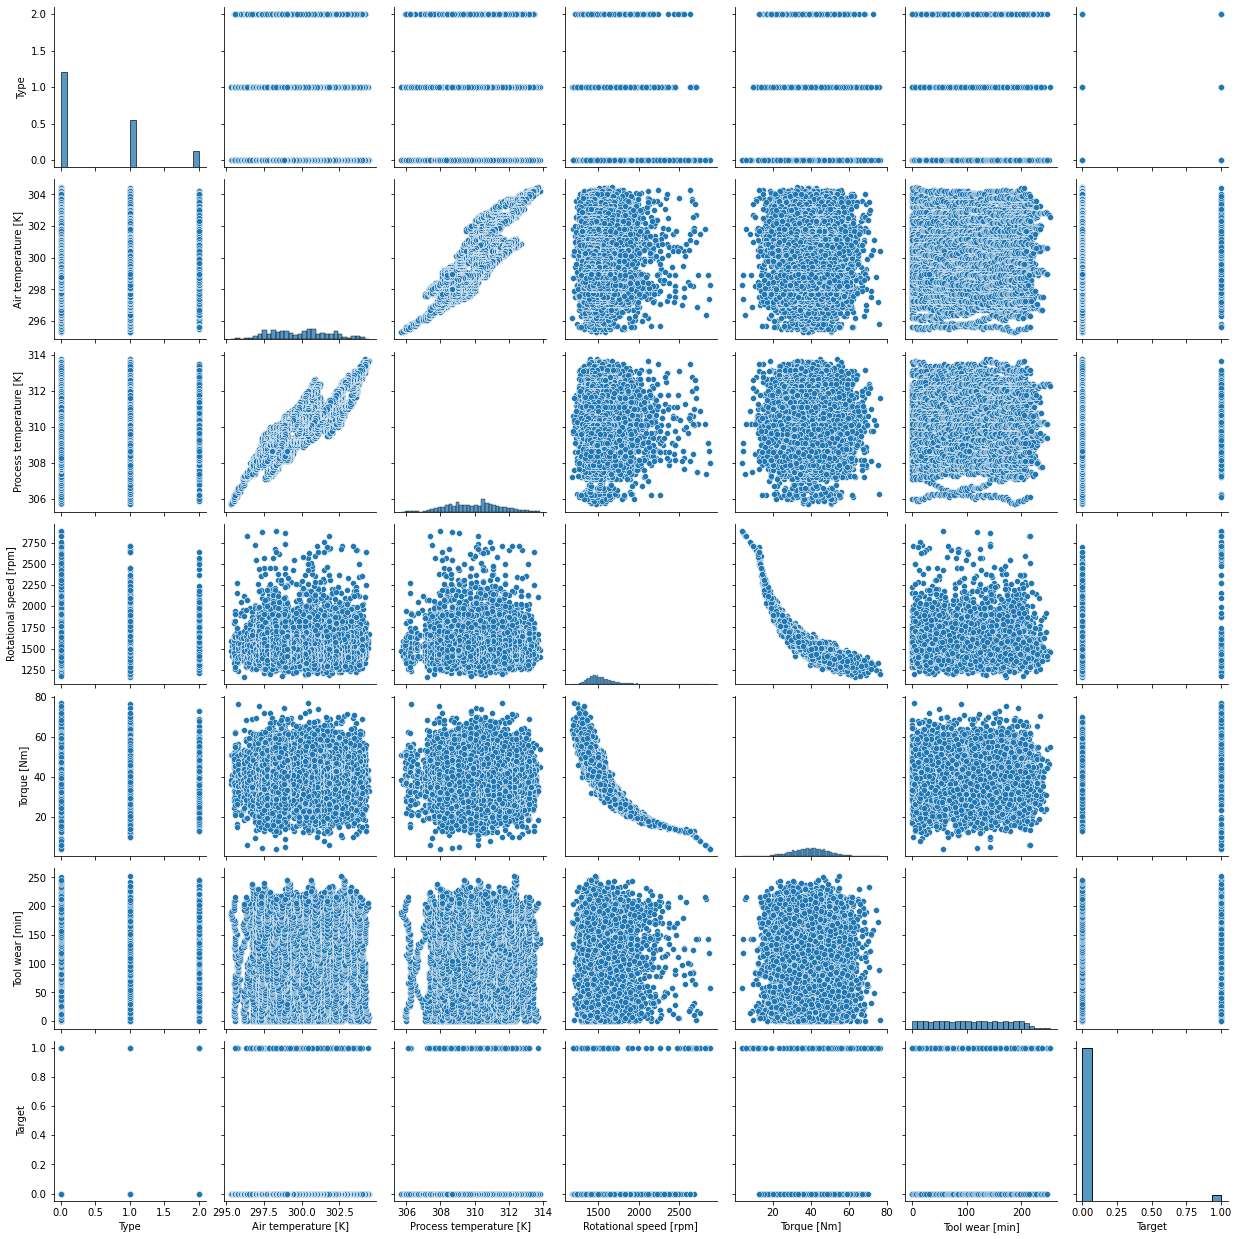

In [23]:
sns.pairplot(df_target)

Ao analizar o gráfico, podemos ver que, aparentemente, temos uma correlação próxima de linear entre as colunas **Process Temperature** X **Air Temperature** e **Rotational Speed** X **Torque**. Porém, nenhuma das colunas parecem ter uma correlação forte com a Coluna **Target**.

Para isso, vamos checar numéricamente as correlações entre as variáveis utilizando dos métodos de Pearson e de Spearman.

##### Pearson

In [24]:
#Por Padrão, a função .corr() utiliza Correlação de Pearson caso nenhum valor seja passado para a função.
df_target.corr()

Type  Air temperature [K]  \
Type                     1.000000            -0.015176   
Air temperature [K]     -0.015176             1.000000   
Process temperature [K] -0.012101             0.876107   
Rotational speed [rpm]  -0.003979             0.022670   
Torque [Nm]             -0.003097            -0.013778   
Tool wear [min]         -0.007255             0.013853   
Target                  -0.036663             0.084453   

                         Process temperature [K]  Rotational speed [rpm]  \
Type                                   -0.012101               -0.003979   
Air temperature [K]                     0.876107                0.022670   
Process temperature [K]                 1.000000                0.019277   
Rotational speed [rpm]                  0.019277                1.000000   
Torque [Nm]                            -0.014061               -0.875027   
Tool wear [min]                         0.013488                0.000223   
Target                                  0.039816               -0.045483   

                         Torque [Nm]  Tool wear [min]    Target  
Type                       -0.003097        -0.007255 -0.036663  
Air temperature [K]        -0.013778         0.013853  0.084453  
Process temperature [K]    -0.014061         0.013488  0.039816  
Rotational speed [rpm]     -0.875027         0.000223 -0.045483  
Torque [Nm]                 1.000000        -0.003093  0.191563  
Tool wear [min]            -0.003093         1.000000  0.105251  
Target                      0.191563         0.105251  1.000000

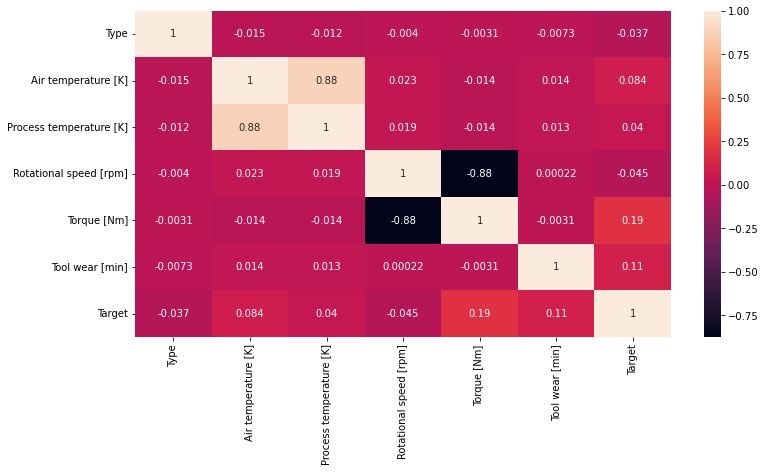

In [25]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_target.corr(), annot=True);

In [26]:
df_target.corr()['Target'].sort_values()

Rotational speed [rpm]    -0.045483
Type                      -0.036663
Process temperature [K]    0.039816
Air temperature [K]        0.084453
Tool wear [min]            0.105251
Torque [Nm]                0.191563
Target                     1.000000
Name: Target, dtype: float64

Com essa análise, podemos ver que nenhuma das colunas tem uma relação muito forte com a coluna **Target**, o que indica que a relação entre elas não é linear.

Porém, ainda nos resta ver a correlação entre ela utilizando a Correlação de Spearman.

##### Spearman

In [27]:
df_target.corr("spearman")

Type  Air temperature [K]  \
Type                     1.000000            -0.013100   
Air temperature [K]     -0.013100             1.000000   
Process temperature [K] -0.009577             0.864217   
Rotational speed [rpm]  -0.003921             0.013732   
Torque [Nm]             -0.000167            -0.011765   
Tool wear [min]         -0.007548             0.013495   
Target                  -0.038184             0.085524   

                         Process temperature [K]  Rotational speed [rpm]  \
Type                                   -0.009577               -0.003921   
Air temperature [K]                     0.864217                0.013732   
Process temperature [K]                 1.000000                0.016985   
Rotational speed [rpm]                  0.016985                1.000000   
Torque [Nm]                            -0.014488               -0.916474   
Tool wear [min]                         0.013702                0.003168   
Target                                  0.043831               -0.166333   

                         Torque [Nm]  Tool wear [min]    Target  
Type                       -0.000167        -0.007548 -0.038184  
Air temperature [K]        -0.011765         0.013495  0.085524  
Process temperature [K]    -0.014488         0.013702  0.043831  
Rotational speed [rpm]     -0.916474         0.003168 -0.166333  
Torque [Nm]                 1.000000        -0.003887  0.169017  
Tool wear [min]            -0.003887         1.000000  0.101477  
Target                      0.169017         0.101477  1.000000

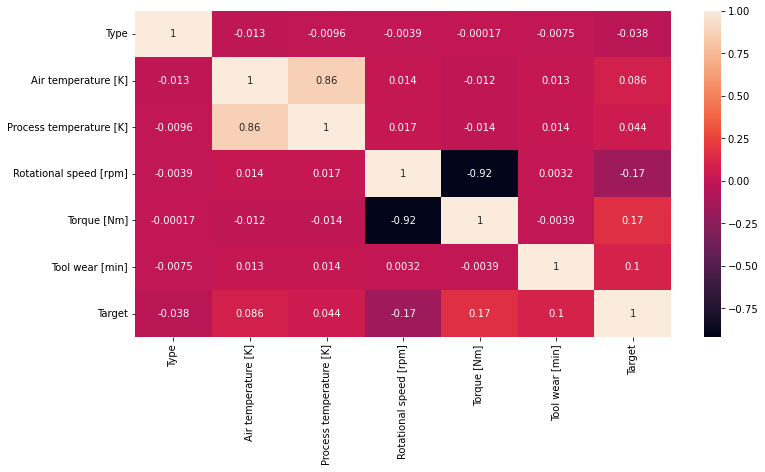

In [28]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_target.corr("spearman"), annot=True);

In [29]:
df_target.corr("spearman")['Target'].sort_values()

Rotational speed [rpm]    -0.166333
Type                      -0.038184
Process temperature [K]    0.043831
Air temperature [K]        0.085524
Tool wear [min]            0.101477
Torque [Nm]                0.169017
Target                     1.000000
Name: Target, dtype: float64

A correlação de Spearman também não aprensentou valores de correlação forte entre nenhuma das colunas e a coluna **Target**, o que indica que a relação delas também não é monotônica.

Nesse momento, precisamos de análises mais profundas para identificar a separabilidade dos Alvos e ver se é realmente possível construir algum modelo para esse problema.

### Preparando os dados para mais análises e para o treino dos modelos

Foi separado em dois conjuntos de dados as colunas de dados e a coluna **Target**. Depois, os conjuntos de dados foram separados em Treino e Teste, na proporção de 80%-20% e de maneira estratificada, ou seja, mantendo as porporções do Alvos em ambos treino e teste. Assim evitamos que os dados cujo Alvo é 1 fique completamente em um dos dois lados.

In [30]:
X = df_target.drop(columns = 'Target')
y = df_target['Target']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
y_train.value_counts(normalize = True)

0    0.96525
1    0.03475
Name: Target, dtype: float64

In [33]:
y_test.value_counts(normalize = True)

0    0.965
1    0.035
Name: Target, dtype: float64

Concatenando os dois conjuntos de dados de treino, podemos fazer uma análise mais profunda sobre os dados que serão utilizados para treino.

In [34]:
df_train = pd.concat([X_train, y_train], axis=1)

df_train

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                        
7053     2                300.6                    310.4   
909      1                295.5                    306.1   
6520     0                301.1                    310.1   
4051     0                301.8                    310.8   
3514     1                301.9                    311.1   
...    ...                  ...                      ...   
1314     0                298.9                    310.2   
6569     0                301.3                    310.6   
6244     0                301.0                    310.4   
966      0                295.8                    306.6   
6403     1                300.1                    309.6   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  
UDI                                                                 
7053                    1510         42.8              124       0  
909                     1822         24.3              164       0  
6520                    1417         46.9               35       0  
4051                    1456         46.6               35       0  
3514                    1417         52.5              171       0  
...                      ...          ...              ...     ...  
1314                    1359         56.9              166       0  
6569                    1521         36.3              166       0  
6244                    2204         16.6              175       0  
966                     1508         46.5               99       0  
6403                    1584         36.7              165       0  

[8000 rows x 7 columns]

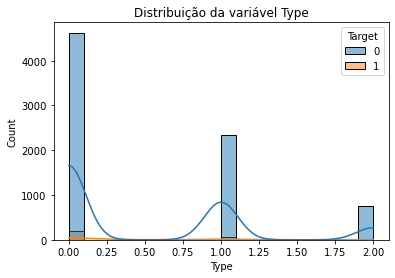

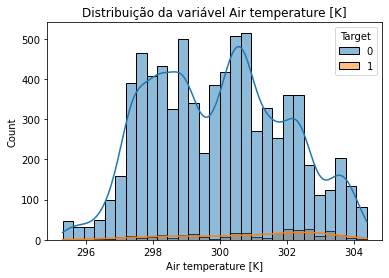

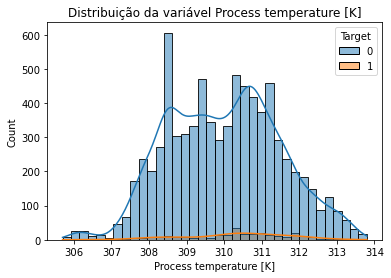

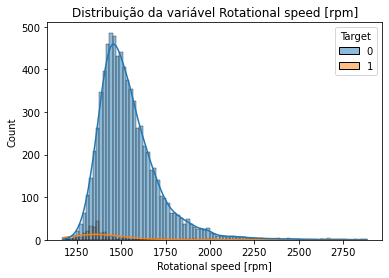

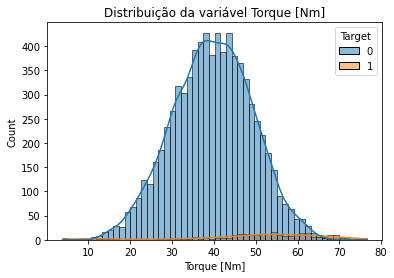

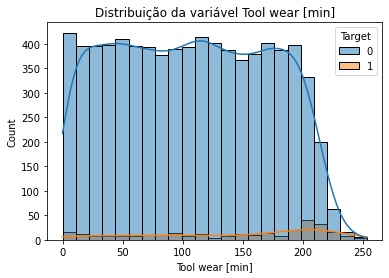

In [35]:
for col in X_train:
    sns.histplot(data=X_train, x=col, kde=True, hue=y_train).set_title(f"Distribuição da variável {col}")
    plt.show()

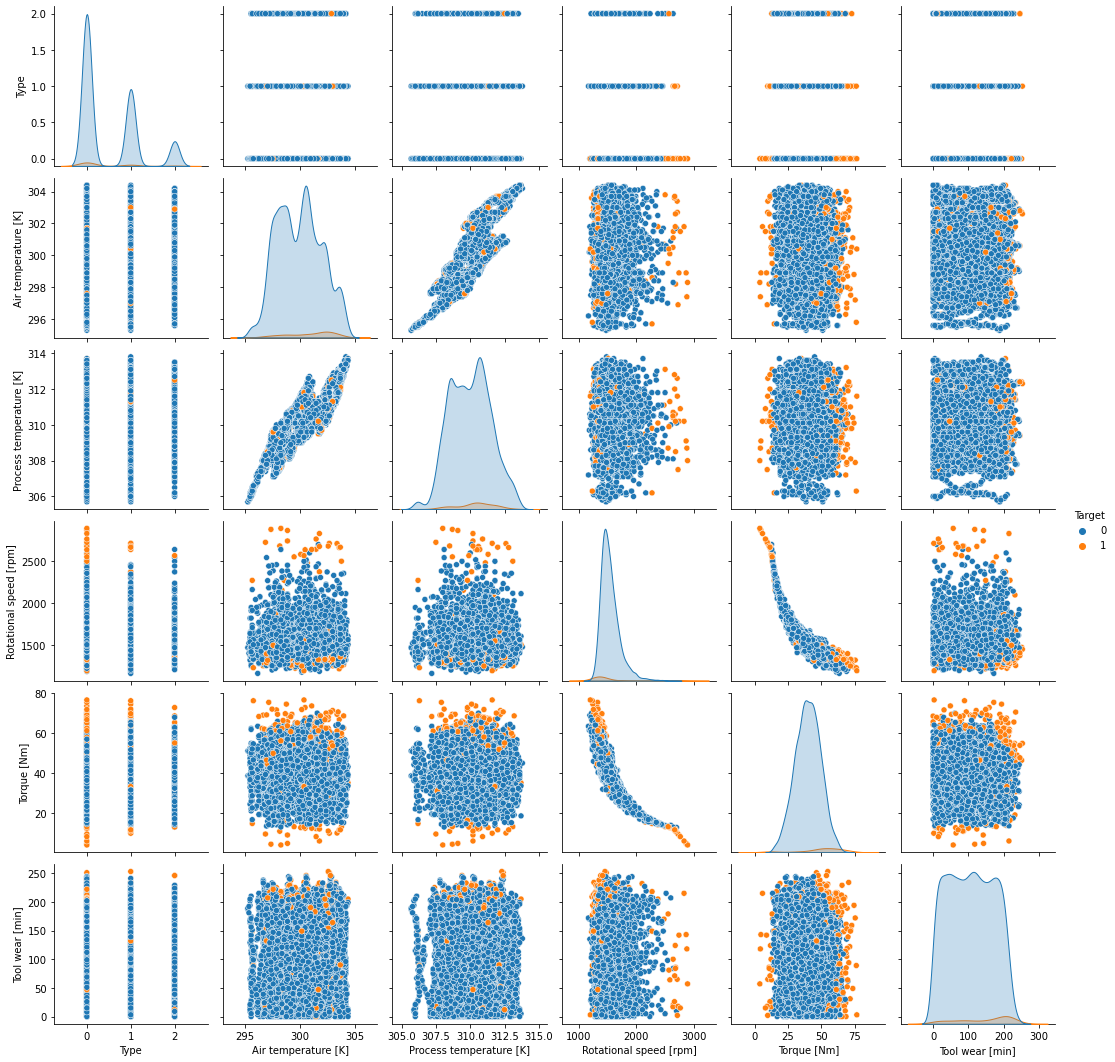

In [36]:
sns.pairplot(df_train, hue='Target')

Analisando os gráficos, conseguimos afirmar que o problema tem separabilidade não trivial. Com base nisso, é de se esperar que métodos lineares não tenham uma performance muito boa. Esta observação indica que, provavelmente, precisaremos de estimadores mais complexos para capiturar o padrão refletido na amostra de treino. Claro, testaremos isso tudo no ciclo de modelagem a seguir, mas é bom já reduzirmos a expectativa para os resultados que iremos obter.

### Teste de Hipótese

O teste de hipótese será usado para validarmos se existe alguma diferença substâncial para os elementos de cada classe e, com isso, podemos dizer que é possível fazer uma separação com algum modelo de machine learning.

O teste consistirá nas seguintes etapas:
- Agrupar os dados pelos níveis categóricos do target e calcular a média de cada uma das features;

- Fazer um teste de hipótese para determinar se, a um nível de significância de 5%, há diferença na média de cada uma das sub-amostras de cada classe, para todas as variáveis;

In [37]:
df_train.groupby('Target').mean()

Type  Air temperature [K]  Process temperature [K]  \
Target                                                           
0       0.498705           299.971588               309.993654   
1       0.381295           300.904676               310.339928   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
Target                                                        
0                  1539.281145    39.670616       106.638565  
1                  1503.151079    49.723741       142.068345

In [38]:
df_train.groupby('Target').var()

Type  Air temperature [K]  Process temperature [K]  \
Target                                                           
0       0.445342             3.945044                 2.191145   
1       0.373945             4.258642                 1.920097   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
Target                                                        
0                 28135.484346    89.984409      3956.612904  
1                145304.114277   275.848676      5454.749825

Pro teste de hipótese, vamos usar a função [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind) do scipy.stats!

Faremos um teste t de Welch (não assumiremos variância populacional igual).

O teste que faremos será:

> $H_0: \ \mu_1 = \mu_2$

> $H_1: \ \mu_1 \neq \mu_2$

Que pode ser reescrito como:

> $H_0: \ \mu_1 - \mu_2 = 0$

> $H_1: \ \mu_1 - \mu_2 \neq 0$

In [39]:
#definindo algumas cores para melhor visualização
class bcolors:
    OKGREEN = '\033[92m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

Para a distribuição da feature Type, temos:

t-statistic: 3.13; p-value: 1.89e-03

Rejeição da H_0: há diferença na média de 'Type' em cada uma das sub-amostras '0' e '1'!


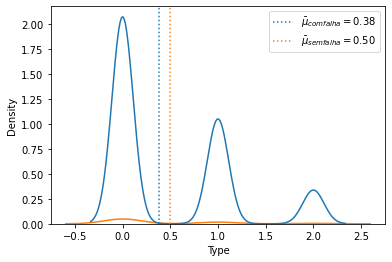



Para a distribuição da feature Air temperature [K], temos:

t-statistic: -7.42; p-value: 1.28e-12

Rejeição da H_0: há diferença na média de 'Air temperature [K]' em cada uma das sub-amostras '0' e '1'!


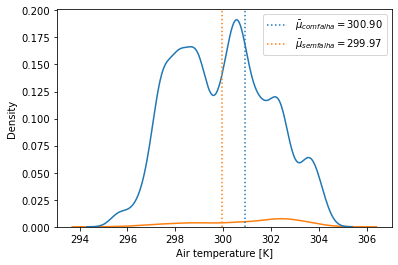



Para a distribuição da feature Process temperature [K], temos:

t-statistic: -4.08; p-value: 5.69e-05

Rejeição da H_0: há diferença na média de 'Process temperature [K]' em cada uma das sub-amostras '0' e '1'!


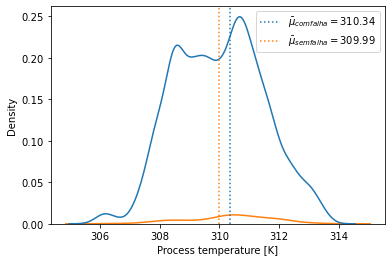



Para a distribuição da feature Rotational speed [rpm], temos:

t-statistic: 1.57; p-value: 1.16e-01

Falha em rejeitar H_0: parece que não há diferença na média de 'Rotational speed [rpm]' em cada uma das sub-amostras '0' e '1'!!


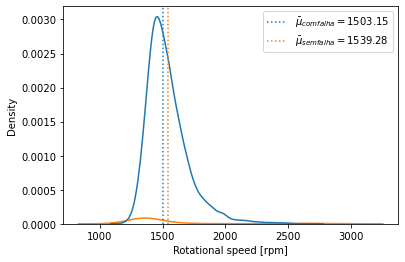



Para a distribuição da feature Torque [Nm], temos:

t-statistic: -10.03; p-value: 1.80e-20

Rejeição da H_0: há diferença na média de 'Torque [Nm]' em cada uma das sub-amostras '0' e '1'!


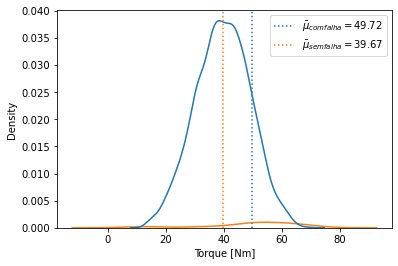



Para a distribuição da feature Tool wear [min], temos:

t-statistic: -7.90; p-value: 5.89e-14

Rejeição da H_0: há diferença na média de 'Tool wear [min]' em cada uma das sub-amostras '0' e '1'!


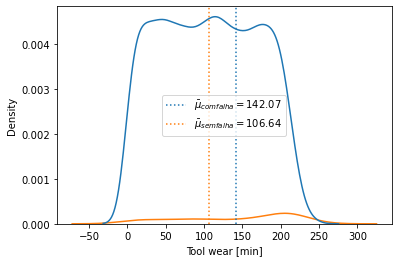

In [40]:
# alpha de 5%
significancia = 0.05
    
# subpops de cada classe
sem_falha = df_train.query("Target == 0")
com_falha = df_train.query("Target == 1")

for col in df_train.drop(columns="Target"):
    
    print(f"Para a distribuição da feature {col}, temos:\n")
    
    t, p_value = ttest_ind(sem_falha[col].values, com_falha[col].values, alternative="two-sided", equal_var=False)
    
    print(f"t-statistic: {t:.2f}; p-value: {p_value:.2e}\n")
    
    if p_value > significancia:
        
        str_fail = f"{bcolors.FAIL}{bcolors.BOLD}"
        str_fail += "Falha em rejeitar H_0: "
        str_fail += f"parece que não há diferença na média de '{col}' em cada uma das sub-amostras '0' e '1'!!"
        str_fail += f"{bcolors.ENDC}"
        
        print(str_fail)
        
    else:
        
        str_rej = f"{bcolors.OKGREEN}{bcolors.BOLD}"
        str_rej += "Rejeição da H_0: "
        str_rej += f"há diferença na média de '{col}' em cada uma das sub-amostras '0' e '1'!"
        str_rej += f"{bcolors.ENDC}"
    
        print(str_rej)
        
    # =======================================
    
    sns.kdeplot(data=df_train, x=col, hue="Target")
    
    # calculando as médias amostrais de cada subpop
    mu_sem_falha, mu_com_falha = sem_falha[col].mean(), com_falha[col].mean()
        
    # "C0" é o azul padrão de primeira cor; "C1" é o laranja padrão de segunda cor
    plt.axvline(x=mu_com_falha, color="C0", label=r"$\bar{\mu}_{com falha}=$"+f"{mu_com_falha:.2f}", ls=":")
    plt.axvline(x=mu_sem_falha, color="C1", label=r"$\bar{\mu}_{sem falha}=$"+f"{mu_sem_falha:.2f}", ls=":")

    plt.legend()
    plt.show()
    
    # =======================================
    
    print()
    print("="*80)
    print()

Com esse teste de hipótese, conseguimos afirmar que existem quase todas as variáveis conseguem gerar uma diferença entre a Falha e a Não Falha, o que indica que conseguiremos sim fazer um modelo, apesar da separabilidade não ser trivial.

## Construíndo Modelos

Vale ressaltar que nesses modelos, a métrica que utilizaremos para comparar os resultados será o Recall, pois é muito mais importante que o programa identifique os dados cujo Target é 1 e não os erre para não gerar nenhuma quebra de equipamento.

### Criando Função para exibir as métricas de classificação

In [41]:
def exibir_metricas(y_train, y_pred_train, y_test, y_pred_test):
    print("\nMétricas de avaliação de treino:")

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    print("\n# =======================================================\n")

    print("\nMétricas de avaliação de teste:")

    print(confusion_matrix(y_test, y_pred_test))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

### Regressão Logística

In [42]:
lista_etapas_lr = [("std_scaler", StandardScaler()), 
                   ("poly", PolynomialFeatures()),
                   ("lr", LogisticRegression(max_iter = 1000))]

pipeline_lr = Pipeline(lista_etapas_lr)

In [43]:
cv_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_lr = make_scorer(recall_score, pos_label = 1)

param_grid_lr = {"lr__solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "poly__degree": range(2,4)}

#verbose=10 pra muitas combinações, os prints vão pro terminal
rando_lr = RandomizedSearchCV(estimator = pipeline_lr, 
                              param_distributions = param_grid_lr,
                              scoring = scoring_lr,
                              cv = cv_lr,
                              verbose = 10,
                              n_iter = 10)

rando_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START lr__solver=liblinear, poly__degree=3.......................
[CV 1/5; 1/10] END lr__solver=liblinear, poly__degree=3;, score=0.473 total time=   0.2s
[CV 2/5; 1/10] START lr__solver=liblinear, poly__degree=3.......................
[CV 2/5; 1/10] END lr__solver=liblinear, poly__degree=3;, score=0.527 total time=   0.2s
[CV 3/5; 1/10] START lr__solver=liblinear, poly__degree=3.......................
[CV 3/5; 1/10] END lr__solver=liblinear, poly__degree=3;, score=0.411 total time=   0.2s
[CV 4/5; 1/10] START lr__solver=liblinear, poly__degree=3.......................
[CV 4/5; 1/10] END lr__solver=liblinear, poly__degree=3;, score=0.482 total time=   0.2s
[CV 5/5; 1/10] START lr__solver=liblinear, poly__degree=3.......................
[CV 5/5; 1/10] END lr__solver=liblinear, poly__degree=3;, score=0.554 total time=   0.2s
[CV 1/5; 2/10] START lr__solver=sag, poly__degree=2.............................
[CV 1/5;

[CV 4/5; 10/10] END lr__solver=newton-cg, poly__degree=3;, score=0.482 total time=   0.2s
[CV 5/5; 10/10] START lr__solver=newton-cg, poly__degree=3......................
[CV 5/5; 10/10] END lr__solver=newton-cg, poly__degree=3;, score=0.554 total time=   0.2s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('poly', PolynomialFeatures()),
                                             ('lr',
                                              LogisticRegression(max_iter=1000))]),
                   param_distributions={'lr__solver': ['lbfgs', 'liblinear',
                                                       'newton-cg',
                                                       'newton-cholesky', 'sag',
                                                       'saga'],
                                        'poly__degree': range(2, 4)},
                   scoring=make_scorer(recall_score, pos_label=1), verbose=10)

In [44]:
print('Melhores Parâmetros:')
print(rando_lr.best_params_)
print('Melhor Métrica Média:')
print(rando_lr.best_score_)

Melhores Parâmetros:
{'poly__degree': 3, 'lr__solver': 'newton-cholesky'}
Melhor Métrica Média:
0.4964935064935065


In [45]:
y_pred_test = rando_lr.predict(X_test)
y_pred_train = rando_lr.predict(X_train)


Métricas de avaliação de treino:


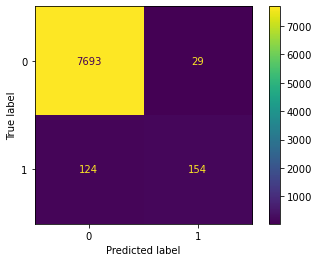

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7722
           1       0.84      0.55      0.67       278

    accuracy                           0.98      8000
   macro avg       0.91      0.78      0.83      8000
weighted avg       0.98      0.98      0.98      8000


# =======================================================


Métricas de avaliação de teste:
[[1923    7]
 [  33   37]]


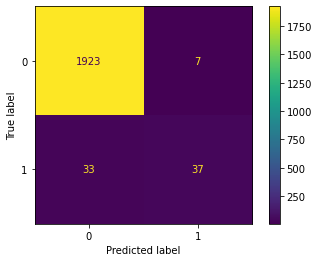

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1930
           1       0.84      0.53      0.65        70

    accuracy                           0.98      2000
   macro avg       0.91      0.76      0.82      2000
weighted avg       0.98      0.98      0.98      2000



In [46]:
exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Utilizando métodos de classificação

### KNN

In [47]:
lista_etapas_knn = [('scaler', StandardScaler()), 
                    ('knn', KNeighborsClassifier())]
pipeline_knn = Pipeline(lista_etapas_knn)

In [48]:
cv_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

scoring_knn = make_scorer(recall_score, pos_label = 1)

param_grid_knn = {"knn__weights" : ["distance", "uniform"],
                  "knn__metric" : ["manhattan", "euclidean", "minkowski"],
                  "knn__n_neighbors" : range(3, 20)}

grid_knn = GridSearchCV(estimator = pipeline_knn, 
                        param_grid = param_grid_knn,
                        scoring = scoring_knn,
                        cv = cv_knn,
                        verbose = 10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 102 candidates, totalling 1020 fits
[CV 1/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 1/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.370 total time=   0.0s
[CV 2/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 2/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.259 total time=   0.0s
[CV 3/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 3/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.286 total time=   0.0s
[CV 4/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 4/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.357 total time=   0.0s
[CV 5/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 5/10; 1/102] EN

[CV 10/10; 4/102] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 1/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 1/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.370 total time=   0.0s
[CV 2/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 2/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.370 total time=   0.0s
[CV 3/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 3/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.286 total time=   0.0s
[CV 4/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 4/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 5/10; 5/102] START knn__metric=manhattan, knn__n_

[CV 10/10; 8/102] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 1/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 1/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.333 total time=   0.0s
[CV 2/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 2/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.333 total time=   0.0s
[CV 3/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 3/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.321 total time=   0.0s
[CV 4/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 4/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 5/10; 9/102] START knn__metric=manhattan, knn__n_

[CV 10/10; 12/102] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 1/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 1/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.296 total time=   0.0s
[CV 2/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 2/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.296 total time=   0.0s
[CV 3/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 3/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.286 total time=   0.0s
[CV 4/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 4/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.179 total time=   0.0s
[CV 5/10; 13/102] START knn__metric=manhatta

[CV 2/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.185 total time=   0.0s
[CV 3/10; 17/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 3/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 4/10; 17/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 4/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 5/10; 17/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 5/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 6/10; 17/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 6/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.071 total time=   0.0s
[CV 7/10; 17/102] START knn__metric

[CV 4/10; 21/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.107 total time=   0.0s
[CV 5/10; 21/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 5/10; 21/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 6/10; 21/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 6/10; 21/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.071 total time=   0.0s
[CV 7/10; 21/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 7/10; 21/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.286 total time=   0.0s
[CV 8/10; 21/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 8/10; 21/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 9/10; 21/102] START knn__metric

[CV 4/10; 25/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.107 total time=   0.0s
[CV 5/10; 25/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 5/10; 25/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.179 total time=   0.0s
[CV 6/10; 25/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 6/10; 25/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.107 total time=   0.0s
[CV 7/10; 25/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 7/10; 25/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 8/10; 25/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 8/10; 25/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.179 total time=   0.0s
[CV 9/10; 25/102] START knn__metric

[CV 7/10; 29/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 8/10; 29/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 8/10; 29/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.143 total time=   0.0s
[CV 9/10; 29/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 9/10; 29/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.036 total time=   0.0s
[CV 10/10; 29/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 10/10; 29/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.143 total time=   0.0s
[CV 1/10; 30/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 1/10; 30/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.148 total time=   0.0s
[CV 2/10; 30/102] START knn__metric

[CV 8/10; 33/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.107 total time=   0.0s
[CV 9/10; 33/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 9/10; 33/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.036 total time=   0.0s
[CV 10/10; 33/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 10/10; 33/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.143 total time=   0.0s
[CV 1/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 1/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.148 total time=   0.0s
[CV 2/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 2/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.111 total time=   0.0s
[CV 3/10; 34/102] START knn__metric=m

[CV 2/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.222 total time=   0.0s
[CV 3/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.286 total time=   0.0s
[CV 4/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.214 total time=   0.0s
[CV 5/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.214 total time=   0.0s
[CV 6/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 6/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.214 total time=   0.0s
[CV 7/10; 38/102] START knn__metric=euclidean, knn__n

[CV 6/10; 42/102] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 7/10; 42/102] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 7/10; 42/102] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 42/102] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 8/10; 42/102] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 9/10; 42/102] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 9/10; 42/102] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.071 total time=   0.0s
[CV 10/10; 42/102] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 10/10; 42/102] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.143 total time=   0.0s
[CV 1/10; 43/102] START knn__metric=euclidean, knn_

[CV 10/10; 46/102] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 1/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 1/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.259 total time=   0.0s
[CV 2/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 2/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.296 total time=   0.0s
[CV 3/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 3/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 4/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 4/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 5/10; 47/102] START knn__metric=euclidea

[CV 4/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 5/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 5/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 6/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 6/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 7/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 7/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 8/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 8/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 9/10; 51/102] START knn__metric

[CV 7/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.250 total time=   0.0s
[CV 8/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 8/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 9/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 9/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.071 total time=   0.0s
[CV 10/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 10/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 1/10; 56/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 1/10; 56/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.222 total time=   0.0s
[CV 2/10; 56/102] START knn__metric

[CV 9/10; 59/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.071 total time=   0.0s
[CV 10/10; 59/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 10/10; 59/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.179 total time=   0.0s
[CV 1/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 1/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.222 total time=   0.0s
[CV 2/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 2/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.148 total time=   0.0s
[CV 3/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 3/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 4/10; 60/102] START knn__metric=euc

[CV 8/10; 63/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=0.179 total time=   0.0s
[CV 9/10; 63/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance
[CV 9/10; 63/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=0.071 total time=   0.0s
[CV 10/10; 63/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance
[CV 10/10; 63/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=0.179 total time=   0.0s
[CV 1/10; 64/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform
[CV 1/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.148 total time=   0.0s
[CV 2/10; 64/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform
[CV 2/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.111 total time=   0.0s
[CV 3/10; 64/102] START knn__metric=e

[CV 3/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.143 total time=   0.0s
[CV 4/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 4/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.071 total time=   0.0s
[CV 5/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 5/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 6/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 6/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 7/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 7/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 68/102] START knn__metric=euclidea

[CV 6/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.214 total time=   0.0s
[CV 7/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 7/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 8/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.214 total time=   0.0s
[CV 9/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 9/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.143 total time=   0.0s
[CV 10/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 10/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 1/10; 73/102] START knn__metric=minkowski, knn_

[CV 1/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.296 total time=   0.0s
[CV 2/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 2/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.296 total time=   0.0s
[CV 3/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 3/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.321 total time=   0.0s
[CV 4/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 4/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 5/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 5/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.321 total time=   0.0s
[CV 6/10; 77/102] START knn__metric=minkowsk

[CV 6/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 7/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 7/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.357 total time=   0.0s
[CV 8/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 8/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.321 total time=   0.0s
[CV 9/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 9/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.107 total time=   0.0s
[CV 10/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 10/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.214 total time=   0.0s
[CV 1/10; 82/102] START knn__metric=minkow

[CV 1/10; 86/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform;, score=0.222 total time=   0.0s
[CV 2/10; 86/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform
[CV 2/10; 86/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform;, score=0.185 total time=   0.0s
[CV 3/10; 86/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform
[CV 3/10; 86/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 4/10; 86/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform
[CV 4/10; 86/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform;, score=0.143 total time=   0.0s
[CV 5/10; 86/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform
[CV 5/10; 86/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=uniform;, score=0.214 total time=   0.0s
[CV 6/10; 86/102] START knn__metric=minkowsk

[CV 3/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.286 total time=   0.0s
[CV 4/10; 90/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform
[CV 4/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 5/10; 90/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform
[CV 5/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.143 total time=   0.0s
[CV 6/10; 90/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform
[CV 6/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.143 total time=   0.0s
[CV 7/10; 90/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform
[CV 7/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 90/102] START knn__metric=minkowsk

[CV 5/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 6/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 6/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 7/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 7/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 8/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.179 total time=   0.0s
[CV 9/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 9/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.071 total time=   0.0s
[CV 10/10; 94/102] START knn__metric=minkows

[CV 6/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.071 total time=   0.0s
[CV 7/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 7/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 8/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 9/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 9/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.036 total time=   0.0s
[CV 10/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 10/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.071 total time=   0.0s
[CV 1/10; 99/102] START knn__metric=minkow

[CV 6/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.107 total time=   0.0s
[CV 7/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 7/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.250 total time=   0.0s
[CV 8/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 8/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.071 total time=   0.0s
[CV 9/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 9/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.036 total time=   0.0s
[CV 10/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 10/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.107 total time=   0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean', 'minkowski'],
                         'knn__n_neighbors': range(3, 20),
                         'knn__weights': ['distance', 'uniform']},
             scoring=make_scorer(recall_score, pos_label=1), verbose=10)

In [49]:
print('Melhores Parâmetros:')
print(grid_knn.best_params_)
print('Melhor Métrica Média:')
print(grid_knn.best_score_)

Melhores Parâmetros:
{'knn__metric': 'euclidean', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
Melhor Métrica Média:
0.3595238095238095


In [50]:
y_pred_test = grid_knn.predict(X_test)
y_pred_train = grid_knn.predict(X_train)


Métricas de avaliação de treino:


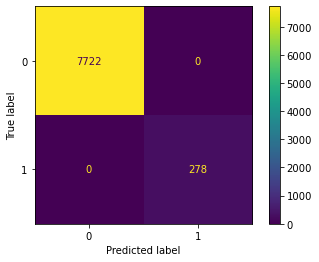

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7722
           1       1.00      1.00      1.00       278

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


# =======================================================


Métricas de avaliação de teste:
[[1922    8]
 [  42   28]]


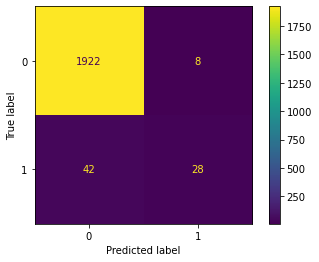

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1930
           1       0.78      0.40      0.53        70

    accuracy                           0.97      2000
   macro avg       0.88      0.70      0.76      2000
weighted avg       0.97      0.97      0.97      2000



In [51]:
exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

### Árvore de Decisões

In [52]:
lista_etapas_dt = [('scaler', StandardScaler()), 
                   ("dt", DecisionTreeClassifier(random_state=42))]
pipeline_dt = Pipeline(lista_etapas_dt)

In [53]:
cv_dt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_dt = make_scorer(recall_score, pos_label = 1)

params_grid_dt = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 11)} 

grid_dt = GridSearchCV(estimator = pipeline_dt, 
                        param_grid = params_grid_dt,
                        scoring = scoring_dt,
                        cv = cv_dt,
                        verbose=10)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 1/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.145 total time=   0.0s
[CV 2/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 2/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.218 total time=   0.0s
[CV 3/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 3/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.232 total time=   0.0s
[CV 4/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 4/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.214 total time=   0.0s
[CV 5/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 5/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.250 total time=   0.0

[CV 4/5; 9/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=best;, score=0.411 total time=   0.0s
[CV 5/5; 9/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=best.....
[CV 5/5; 9/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=best;, score=0.554 total time=   0.0s
[CV 1/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 1/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.164 total time=   0.0s
[CV 2/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 2/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.309 total time=   0.0s
[CV 3/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 3/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.411 total time=   0.0s
[CV 4/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 4/5; 10/36] END dt__criterion=gini, dt__max_dep

[CV 1/5; 19/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=best;, score=0.164 total time=   0.0s
[CV 2/5; 19/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=best.
[CV 2/5; 19/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=best;, score=0.091 total time=   0.0s
[CV 3/5; 19/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=best.
[CV 3/5; 19/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=best;, score=0.089 total time=   0.0s
[CV 4/5; 19/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=best.
[CV 4/5; 19/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=best;, score=0.125 total time=   0.0s
[CV 5/5; 19/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=best.
[CV 5/5; 19/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=best;, score=0.036 total time=   0.0s
[CV 1/5; 20/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=random
[CV 1/5; 20/36] END dt__criterion=entro

[CV 4/5; 27/36] END dt__criterion=entropy, dt__max_depth=6, dt__splitter=best;, score=0.536 total time=   0.0s
[CV 5/5; 27/36] START dt__criterion=entropy, dt__max_depth=6, dt__splitter=best.
[CV 5/5; 27/36] END dt__criterion=entropy, dt__max_depth=6, dt__splitter=best;, score=0.536 total time=   0.0s
[CV 1/5; 28/36] START dt__criterion=entropy, dt__max_depth=6, dt__splitter=random
[CV 1/5; 28/36] END dt__criterion=entropy, dt__max_depth=6, dt__splitter=random;, score=0.164 total time=   0.0s
[CV 2/5; 28/36] START dt__criterion=entropy, dt__max_depth=6, dt__splitter=random
[CV 2/5; 28/36] END dt__criterion=entropy, dt__max_depth=6, dt__splitter=random;, score=0.382 total time=   0.0s
[CV 3/5; 28/36] START dt__criterion=entropy, dt__max_depth=6, dt__splitter=random
[CV 3/5; 28/36] END dt__criterion=entropy, dt__max_depth=6, dt__splitter=random;, score=0.411 total time=   0.0s
[CV 4/5; 28/36] START dt__criterion=entropy, dt__max_depth=6, dt__splitter=random
[CV 4/5; 28/36] END dt__criter

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random']},
             scoring=make_scorer(recall_score, pos_label=1), verbose=10)

In [54]:
print('Melhores Parâmetros:')
print(grid_dt.best_params_)
print('Melhor Métrica Média:')
print(grid_dt.best_score_)

Melhores Parâmetros:
{'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__splitter': 'best'}
Melhor Métrica Média:
0.6442207792207792


In [55]:
y_pred_test = grid_dt.predict(X_test)
y_pred_train = grid_dt.predict(X_train)


Métricas de avaliação de treino:


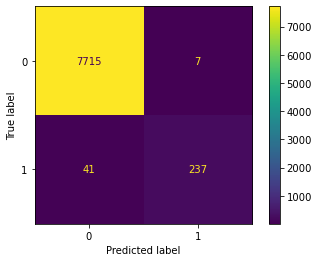

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7722
           1       0.97      0.85      0.91       278

    accuracy                           0.99      8000
   macro avg       0.98      0.93      0.95      8000
weighted avg       0.99      0.99      0.99      8000


# =======================================================


Métricas de avaliação de teste:
[[1923    7]
 [  16   54]]


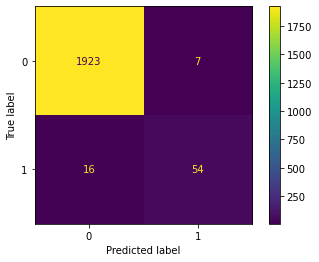

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1930
           1       0.89      0.77      0.82        70

    accuracy                           0.99      2000
   macro avg       0.94      0.88      0.91      2000
weighted avg       0.99      0.99      0.99      2000



In [56]:
exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Utilizando métodos de Ensemble

### Random Forest

In [57]:
lista_etapas_rf = [("std_scaler", StandardScaler()), 
                   ("rf", RandomForestClassifier(n_jobs=-1))]

pipeline_rf = Pipeline(lista_etapas_rf)

In [58]:
cv_rf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


scoring_rf = make_scorer(recall_score, pos_label= 1 )


param_grid_rf = {"rf__n_estimators" : range(100, 600, 100),
                 "rf__max_depth" : range(3, 6),
                 "rf__max_features" : ['sqrt', 'log2'],
                 "rf__criterion" : ['entropy', 'gini']}

grid_rf = GridSearchCV(estimator = pipeline_rf, 
                        param_grid = param_grid_rf,
                        scoring = scoring_rf,
                        cv = cv_rf,
                        verbose = 10)


grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 1/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.074 total time=   1.3s
[CV 2/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 2/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.074 total time=   0.0s
[CV 3/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 3/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.107 total time=   0.0s
[CV 4/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 4/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10

[CV 4/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.000 total time=   0.2s
[CV 5/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 5/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.000 total time=   0.2s
[CV 6/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 6/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.036 total time=   0.2s
[CV 7/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 7/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.107 total time=   0.2s
[CV 8/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 8/10; 4/60] END rf__crit

[CV 9/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.036 total time=   0.1s
[CV 10/10; 7/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200
[CV 10/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.036 total time=   0.1s
[CV 1/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 1/10; 8/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.111 total time=   0.2s
[CV 2/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 2/10; 8/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.074 total time=   0.2s
[CV 3/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 3/10; 8/60] END rf__cr

[CV 4/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.143 total time=   0.0s
[CV 5/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 5/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.286 total time=   0.0s
[CV 6/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 6/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.143 total time=   0.0s
[CV 7/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 7/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.357 total time=   0.0s
[CV 8/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 8/10; 11/60] END

[CV 8/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.143 total time=   0.2s
[CV 9/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 9/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.143 total time=   0.3s
[CV 10/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 10/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.250 total time=   0.2s
[CV 1/10; 15/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500
[CV 1/10; 15/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500;, score=0.148 total time=   0.3s
[CV 2/10; 15/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500
[CV 2/10; 15/60] E

[CV 2/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.148 total time=   0.2s
[CV 3/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 3/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.393 total time=   0.2s
[CV 4/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 4/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.214 total time=   0.2s
[CV 5/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 5/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.214 total time=   0.2s
[CV 6/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 6/10; 18/60] END

[CV 6/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.143 total time=   0.0s
[CV 7/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 7/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.357 total time=   0.0s
[CV 8/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 8/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.179 total time=   0.0s
[CV 9/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 9/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.250 total time=   0.0s
[CV 10/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 10/10; 21/60] E

[CV 10/10; 24/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=400;, score=0.321 total time=   0.3s
[CV 1/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 1/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.222 total time=   0.3s
[CV 2/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 2/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.148 total time=   0.3s
[CV 3/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 3/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.393 total time=   0.4s
[CV 4/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 4/10; 25/60] EN

[CV 4/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.250 total time=   0.2s
[CV 5/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 5/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.321 total time=   0.2s
[CV 6/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 6/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.143 total time=   0.2s
[CV 7/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 7/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.357 total time=   0.2s
[CV 8/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 8/10; 28/60] END

[CV 9/10; 31/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.286 total time=   0.0s
[CV 10/10; 31/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 10/10; 31/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.179 total time=   0.0s
[CV 1/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 1/10; 32/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200;, score=0.148 total time=   0.1s
[CV 2/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 2/10; 32/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200;, score=0.111 total time=   0.1s
[CV 3/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 3/10; 32/60] END rf__criterion=gini, r

[CV 4/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.179 total time=   0.3s
[CV 5/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 5/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.179 total time=   0.3s
[CV 6/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 6/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.107 total time=   0.3s
[CV 7/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 7/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.286 total time=   0.3s
[CV 8/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 8/10; 35/60] END rf__criterion=gini, rf_

[CV 9/10; 38/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.214 total time=   0.2s
[CV 10/10; 38/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 10/10; 38/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.214 total time=   0.2s
[CV 1/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 1/10; 39/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400;, score=0.148 total time=   0.2s
[CV 2/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 2/10; 39/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400;, score=0.111 total time=   0.2s
[CV 3/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 3/10; 39/60] END rf__criterion=gini, r

[CV 4/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.214 total time=   0.1s
[CV 5/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 5/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.250 total time=   0.1s
[CV 6/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 6/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.143 total time=   0.1s
[CV 7/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 7/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.286 total time=   0.1s
[CV 8/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 8/10; 42/60] END rf__criterion=gini, rf_

[CV 9/10; 45/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500;, score=0.286 total time=   0.5s
[CV 10/10; 45/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500
[CV 10/10; 45/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500;, score=0.250 total time=   0.4s
[CV 1/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 1/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.185 total time=   0.0s
[CV 2/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 2/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.111 total time=   0.0s
[CV 3/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 3/10; 46/60] END rf__criterion=gini, r

[CV 4/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.214 total time=   0.2s
[CV 5/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 5/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.286 total time=   0.2s
[CV 6/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 6/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.107 total time=   0.2s
[CV 7/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 7/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.286 total time=   0.2s
[CV 8/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 8/10; 49/60] END rf__criterion=gini, rf_

[CV 9/10; 52/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=200;, score=0.286 total time=   0.1s
[CV 10/10; 52/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=200
[CV 10/10; 52/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=200;, score=0.250 total time=   0.1s
[CV 1/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 1/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.222 total time=   0.2s
[CV 2/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 2/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.148 total time=   0.2s
[CV 3/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 3/10; 53/60] END rf__criterion=gini, r

[CV 4/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.250 total time=   0.0s
[CV 5/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 5/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.250 total time=   0.0s
[CV 6/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 6/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.179 total time=   0.0s
[CV 7/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 7/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.357 total time=   0.0s
[CV 8/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 8/10; 56/60] END rf__criterion=gini, rf_

[CV 9/10; 59/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=400;, score=0.321 total time=   0.2s
[CV 10/10; 59/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=400
[CV 10/10; 59/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=400;, score=0.250 total time=   0.2s
[CV 1/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 1/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.222 total time=   0.3s
[CV 2/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 2/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.148 total time=   0.3s
[CV 3/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 3/10; 60/60] END rf__criterion=gini, r

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rf__criterion': ['entropy', 'gini'],
                         'rf__max_depth': range(3, 6),
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': range(100, 600, 100)},
             scoring=make_scorer(recall_score, pos_label=1), verbose=10)

In [59]:
print('Melhores Parâmetros:')
print(grid_rf.best_params_)
print('Melhor Métrica Média:')
print(grid_rf.best_score_)

Melhores Parâmetros:
{'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__n_estimators': 100}
Melhor Métrica Média:
0.26931216931216934


In [60]:
y_pred_test = grid_rf.predict(X_test)
y_pred_train = grid_rf.predict(X_train)


Métricas de avaliação de treino:


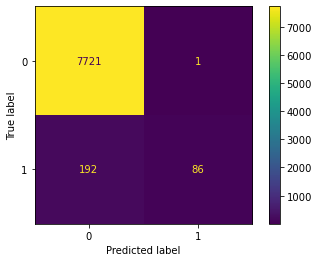

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7722
           1       0.99      0.31      0.47       278

    accuracy                           0.98      8000
   macro avg       0.98      0.65      0.73      8000
weighted avg       0.98      0.98      0.97      8000


# =======================================================


Métricas de avaliação de teste:
[[1929    1]
 [  53   17]]


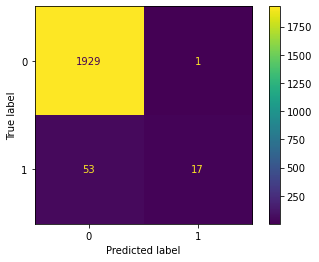

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1930
           1       0.94      0.24      0.39        70

    accuracy                           0.97      2000
   macro avg       0.96      0.62      0.69      2000
weighted avg       0.97      0.97      0.97      2000



In [61]:
exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

### AdaBoost

In [62]:
lista_etapas_ab = [("std_scaler", StandardScaler()), 
                   ("ab", AdaBoostClassifier())]

pipeline_ab = Pipeline(lista_etapas_ab)

In [63]:
cv_ab = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


scoring_ab = make_scorer(recall_score, pos_label= 1 )


param_grid_ab = {"ab__n_estimators" : range(25, 100, 10)}

grid_ab = GridSearchCV(estimator = pipeline_ab, 
                        param_grid = param_grid_ab,
                        scoring = scoring_ab,
                        cv = cv_ab,
                        verbose = 10)


grid_ab.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START ab__n_estimators=25........................................
[CV 1/10; 1/8] END .........ab__n_estimators=25;, score=0.444 total time=   0.0s
[CV 2/10; 1/8] START ab__n_estimators=25........................................
[CV 2/10; 1/8] END .........ab__n_estimators=25;, score=0.296 total time=   0.0s
[CV 3/10; 1/8] START ab__n_estimators=25........................................
[CV 3/10; 1/8] END .........ab__n_estimators=25;, score=0.571 total time=   0.0s
[CV 4/10; 1/8] START ab__n_estimators=25........................................
[CV 4/10; 1/8] END .........ab__n_estimators=25;, score=0.429 total time=   0.0s
[CV 5/10; 1/8] START ab__n_estimators=25........................................
[CV 5/10; 1/8] END .........ab__n_estimators=25;, score=0.464 total time=   0.0s
[CV 6/10; 1/8] START ab__n_estimators=25........................................
[CV 6/10; 1/8] END .........ab__n_estimators=25;

[CV 1/10; 6/8] END .........ab__n_estimators=75;, score=0.519 total time=   0.2s
[CV 2/10; 6/8] START ab__n_estimators=75........................................
[CV 2/10; 6/8] END .........ab__n_estimators=75;, score=0.333 total time=   0.2s
[CV 3/10; 6/8] START ab__n_estimators=75........................................
[CV 3/10; 6/8] END .........ab__n_estimators=75;, score=0.607 total time=   0.2s
[CV 4/10; 6/8] START ab__n_estimators=75........................................
[CV 4/10; 6/8] END .........ab__n_estimators=75;, score=0.429 total time=   0.2s
[CV 5/10; 6/8] START ab__n_estimators=75........................................
[CV 5/10; 6/8] END .........ab__n_estimators=75;, score=0.429 total time=   0.2s
[CV 6/10; 6/8] START ab__n_estimators=75........................................
[CV 6/10; 6/8] END .........ab__n_estimators=75;, score=0.321 total time=   0.2s
[CV 7/10; 6/8] START ab__n_estimators=75........................................
[CV 7/10; 6/8] END .........

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('ab', AdaBoostClassifier())]),
             param_grid={'ab__n_estimators': range(25, 100, 10)},
             scoring=make_scorer(recall_score, pos_label=1), verbose=10)

In [64]:
print('Melhores Parâmetros:')
print(grid_ab.best_params_)
print('Melhor Métrica Média:')
print(grid_ab.best_score_)

Melhores Parâmetros:
{'ab__n_estimators': 85}
Melhor Métrica Média:
0.42447089947089955


In [65]:
y_pred_test = grid_ab.predict(X_test)
y_pred_train = grid_ab.predict(X_train)


Métricas de avaliação de treino:


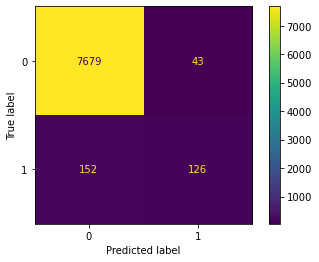

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7722
           1       0.75      0.45      0.56       278

    accuracy                           0.98      8000
   macro avg       0.86      0.72      0.78      8000
weighted avg       0.97      0.98      0.97      8000


# =======================================================


Métricas de avaliação de teste:
[[1921    9]
 [  41   29]]


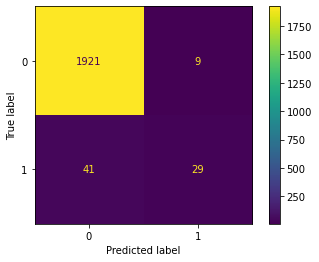

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1930
           1       0.76      0.41      0.54        70

    accuracy                           0.97      2000
   macro avg       0.87      0.70      0.76      2000
weighted avg       0.97      0.97      0.97      2000



In [66]:
exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Resultado do Teste 1 Parte 1:

após fazer a predição utilizando de cinco modelos diferentes temos um ranking de recall:

- 1º - Árvore de decisões - 0.77
- 2º - Regressão Logistica - 0.53
- 3º - Ada Boost - 0.41
- 4º - Knn - 0.40
- 5º - Random Forest - 0.21

## Parte 2:

#### Repetiremos alguns passos da parte 1 para analisarmos o novo conjunto de dados. Com isso, será somente explicado os passos que forem diferentes

In [67]:
df_type = df_mp[df_mp['Target'] == 1].drop(columns = 'Target')
df_type

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                        
51       0                298.9                    309.1   
70       0                298.9                    309.0   
78       0                298.8                    308.9   
161      0                298.4                    308.2   
162      0                298.3                    308.1   
...    ...                  ...                      ...   
9759     0                298.6                    309.8   
9765     0                298.5                    309.5   
9823     0                298.5                    309.4   
9831     0                298.3                    309.3   
9975     0                298.6                    308.2   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]        Failure Type  
UDI                                                                             
51                      2861          4.6              143       Power Failure  
70                      1410         65.7              191       Power Failure  
78                      1455         41.3              208   Tool Wear Failure  
161                     1282         60.7              216  Overstrain Failure  
162                     1412         52.3              218  Overstrain Failure  
...                      ...          ...              ...                 ...  
9759                    2271         16.2              218   Tool Wear Failure  
9765                    1294         66.7               12       Power Failure  
9823                    1360         60.9              187  Overstrain Failure  
9831                    1337         56.1              206  Overstrain Failure  
9975                    1361         68.2              172       Power Failure  

[348 rows x 7 columns]

In [68]:
for column in ["Type", "Failure Type"]:
    print(f"Coluna: {column}")
    print(df_type[column].value_counts())
    print(f'\n{"="*80}\n')

Coluna: Type
0    243
1     81
2     24
Name: Type, dtype: int64


Coluna: Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Random Failures              18
Name: Failure Type, dtype: int64




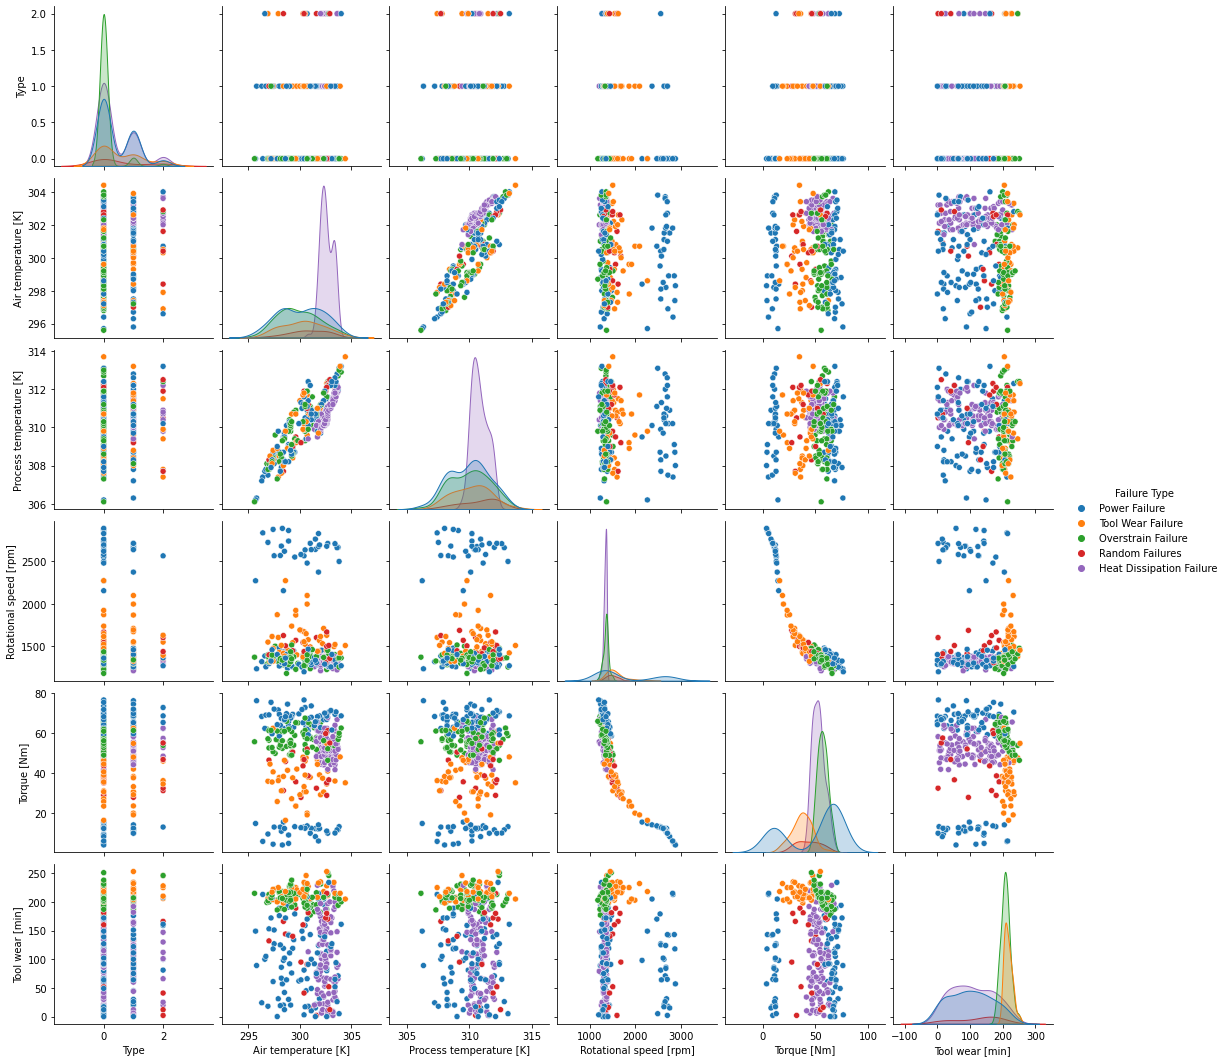

In [69]:
sns.pairplot(df_type, hue = 'Failure Type')

Utilizando da função get_dummies, foi separado todos os tipos de falhas para que seja possível ver a correlação das colunas com os tipos de falhas.

In [70]:
df_dummies = pd.get_dummies(df_type, columns = ['Failure Type'])
df_dummies.head(2)

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                       
51      0                298.9                    309.1   
70      0                298.9                    309.0   

     Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  \
UDI                                                         
51                     2861          4.6              143   
70                     1410         65.7              191   

     Failure Type_Heat Dissipation Failure  Failure Type_Overstrain Failure  \
UDI                                                                           
51                                       0                                0   
70                                       0                                0   

     Failure Type_Power Failure  Failure Type_Random Failures  \
UDI                                                             
51                            1                             0   
70                            1                             0   

     Failure Type_Tool Wear Failure  
UDI                                  
51                                0  
70                                0

##### Pearson

In [71]:
df_dummies.corr()

Type  Air temperature [K]  \
Type                                   1.000000             0.069175   
Air temperature [K]                    0.069175             1.000000   
Process temperature [K]                0.016971             0.844181   
Rotational speed [rpm]                 0.032758            -0.140207   
Torque [Nm]                           -0.051142             0.032242   
Tool wear [min]                       -0.099355            -0.222462   
Failure Type_Heat Dissipation Failure  0.045255             0.561616   
Failure Type_Overstrain Failure       -0.259154            -0.268826   
Failure Type_Power Failure             0.061240            -0.244434   
Failure Type_Random Failures           0.070864            -0.014550   
Failure Type_Tool Wear Failure         0.130988            -0.113714   

                                       Process temperature [K]  \
Type                                                  0.016971   
Air temperature [K]                                   0.844181   
Process temperature [K]                               1.000000   
Rotational speed [rpm]                               -0.074960   
Torque [Nm]                                           0.013025   
Tool wear [min]                                      -0.101739   
Failure Type_Heat Dissipation Failure                 0.241591   
Failure Type_Overstrain Failure                      -0.103687   
Failure Type_Power Failure                           -0.161217   
Failure Type_Random Failures                          0.074511   
Failure Type_Tool Wear Failure                       -0.042643   

                                       Rotational speed [rpm]  Torque [Nm]  \
Type                                                 0.032758    -0.051142   
Air temperature [K]                                 -0.140207     0.032242   
Process temperature [K]                             -0.074960     0.013025   
Rotational speed [rpm]                               1.000000    -0.876105   
Torque [Nm]                                         -0.876105     1.000000   
Tool wear [min]                                     -0.108515    -0.018829   
Failure Type_Heat Dissipation Failure               -0.286499     0.115922   
Failure Type_Overstrain Failure                     -0.200480     0.226020   
Failure Type_Power Failure                           0.432841    -0.057646   
Failure Type_Random Failures                        -0.003931    -0.093712   
Failure Type_Tool Wear Failure                       0.075972    -0.303910   

                                       Tool wear [min]  \
Type                                         -0.099355   
Air temperature [K]                          -0.222462   
Process temperature [K]                      -0.101739   
Rotational speed [rpm]                       -0.108515   
Torque [Nm]                                  -0.018829   
Tool wear [min]                               1.000000   
Failure Type_Heat Dissipation Failure        -0.340003   
Failure Type_Overstrain Failure               0.480279   
Failure Type_Power Failure                   -0.348398   
Failure Type_Random Failures                 -0.074966   
Failure Type_Tool Wear Failure                0.388542   

                                       Failure Type_Heat Dissipation Failure  \
Type                                                                0.045255   
Air temperature [K]                                                 0.561616   
Process temperature [K]                                             0.241591   
Rotational speed [rpm]                                             -0.286499   
Torque [Nm]                                                         0.115922   
Tool wear [min]                                                    -0.340003   
Failure Type_Heat Dissipation Failure                               1.000000   
Failure Type_Overstrain Failure                                    -0.370270   
Failure Type_Power Failure     

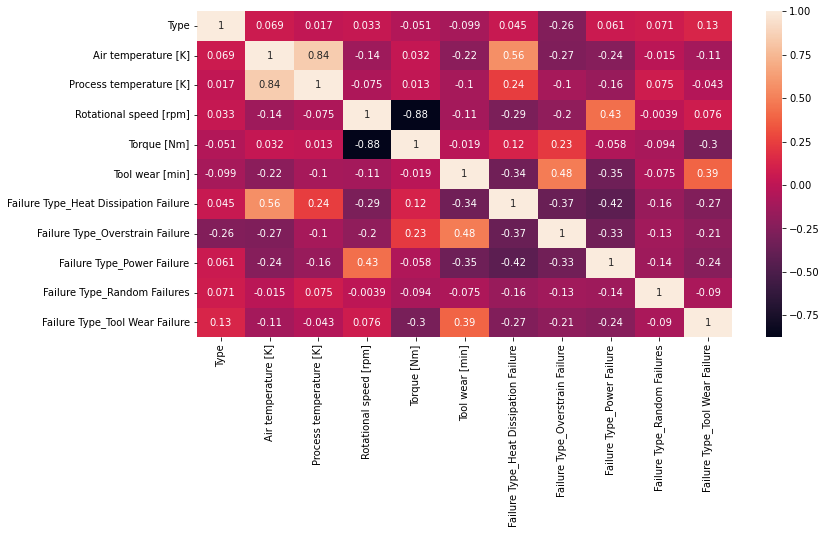

In [72]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_dummies.corr(), annot=True);

##### Spearman

In [73]:
df_dummies.corr('spearman')

Type  Air temperature [K]  \
Type                                   1.000000             0.071414   
Air temperature [K]                    0.071414             1.000000   
Process temperature [K]                0.010656             0.799795   
Rotational speed [rpm]                 0.062888            -0.196825   
Torque [Nm]                           -0.053504            -0.058194   
Tool wear [min]                       -0.103002            -0.235606   
Failure Type_Heat Dissipation Failure  0.052996             0.577957   
Failure Type_Overstrain Failure       -0.275744            -0.273863   
Failure Type_Power Failure             0.088394            -0.238982   
Failure Type_Random Failures           0.038067            -0.021510   
Failure Type_Tool Wear Failure         0.126423            -0.132852   

                                       Process temperature [K]  \
Type                                                  0.010656   
Air temperature [K]                                   0.799795   
Process temperature [K]                               1.000000   
Rotational speed [rpm]                               -0.086553   
Torque [Nm]                                          -0.042646   
Tool wear [min]                                      -0.096842   
Failure Type_Heat Dissipation Failure                 0.221280   
Failure Type_Overstrain Failure                      -0.100361   
Failure Type_Power Failure                           -0.144691   
Failure Type_Random Failures                          0.086573   
Failure Type_Tool Wear Failure                       -0.048399   

                                       Rotational speed [rpm]  Torque [Nm]  \
Type                                                 0.062888    -0.053504   
Air temperature [K]                                 -0.196825    -0.058194   
Process temperature [K]                             -0.086553    -0.042646   
Rotational speed [rpm]                               1.000000    -0.725744   
Torque [Nm]                                         -0.725744     1.000000   
Tool wear [min]                                      0.184257    -0.151231   
Failure Type_Heat Dissipation Failure               -0.361405    -0.045615   
Failure Type_Overstrain Failure                     -0.118841     0.204584   
Failure Type_Power Failure                           0.118146     0.231025   
Failure Type_Random Failures                         0.179856    -0.149760   
Failure Type_Tool Wear Failure                       0.375315    -0.398627   

                                       Tool wear [min]  \
Type                                         -0.103002   
Air temperature [K]                          -0.235606   
Process temperature [K]                      -0.096842   
Rotational speed [rpm]                        0.184257   
Torque [Nm]                                  -0.151231   
Tool wear [min]                               1.000000   
Failure Type_Heat Dissipation Failure        -0.360588   
Failure Type_Overstrain Failure               0.485290   
Failure Type_Power Failure                   -0.365492   
Failure Type_Random Failures                 -0.098100   
Failure Type_Tool Wear Failure                0.448940   

                                       Failure Type_Heat Dissipation Failure  \
Type                                                                0.052996   
Air temperature [K]                                                 0.577957   
Process temperature [K]                                             0.221280   
Rotational speed [rpm]                                             -0.361405   
Torque [Nm]                                                        -0.045615   
Tool wear [min]                                                    -0.360588   
Failure Type_Heat Dissipation Failure                               1.000000   
Failure Type_Overstrain Failure                                    -0.370270   
Failure Type_Power Failure     

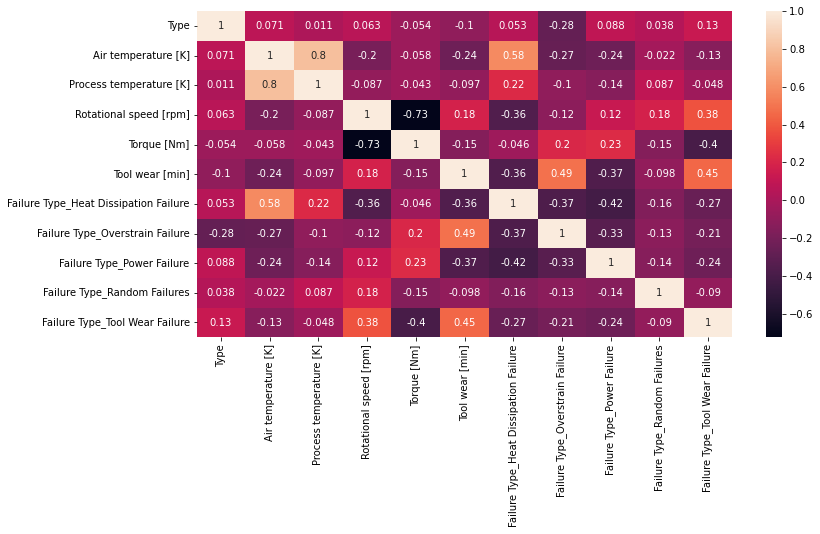

In [74]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_dummies.corr('spearman'), annot=True);

Analisando os 2 mapas de calor, conseguimos identificar algumas relações interessantes. Algumas delas são:
- Torque tem uma correlação média linear e monotônica com as falhas por Sobretensão e Desgaste de Equipamento.
- A falha por Desgate de Equipamento possui uma correlação linear quase nula com a Velocidade Rotacional, porém tem um correlação monotônica média com ela.
- A falha por dissipação de calor tem uma correlação quase forte e positiva com a Temperatura do Ar e possue correlações médias negativas com a velocidade rotacional e com o desgaste do equipamento.

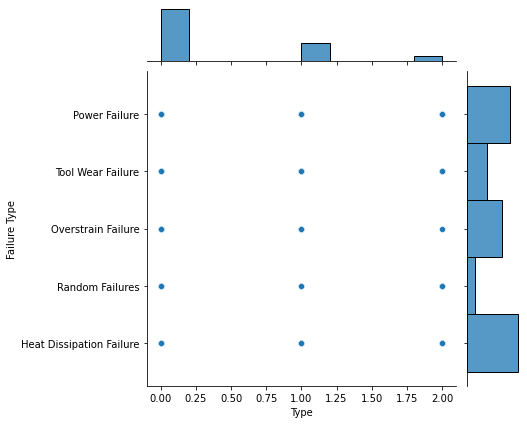

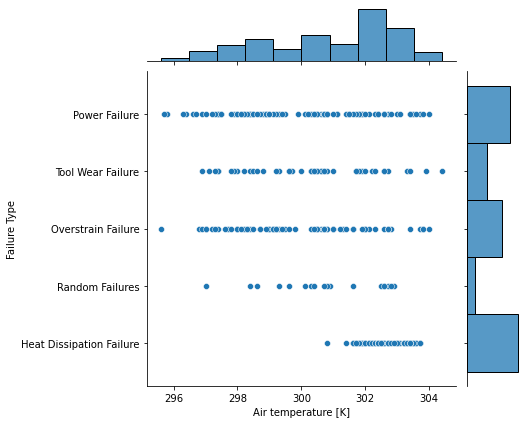

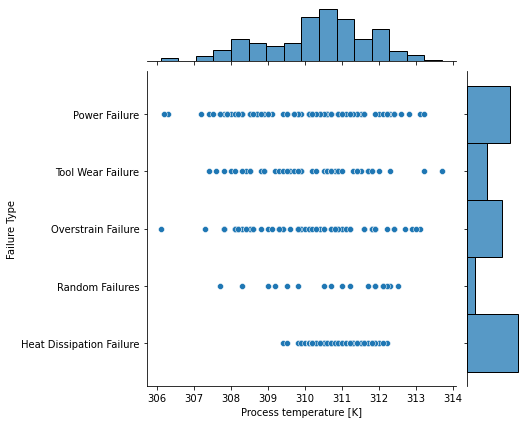

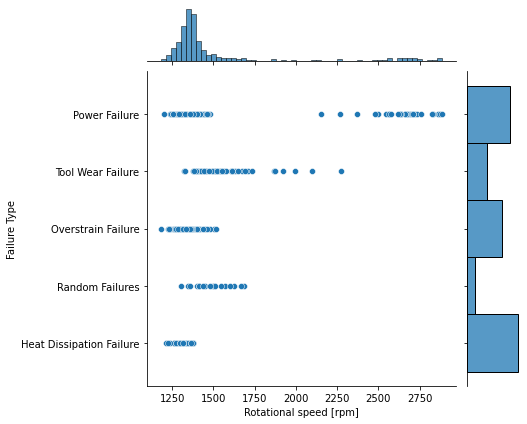

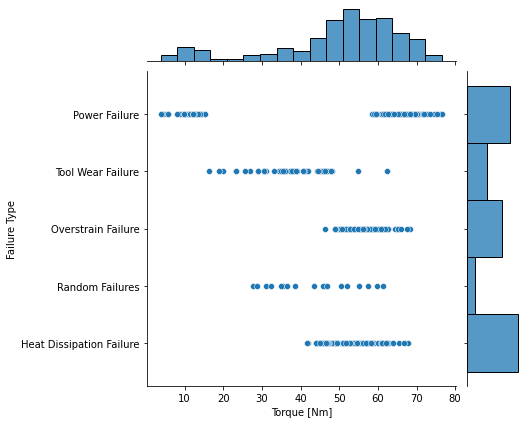

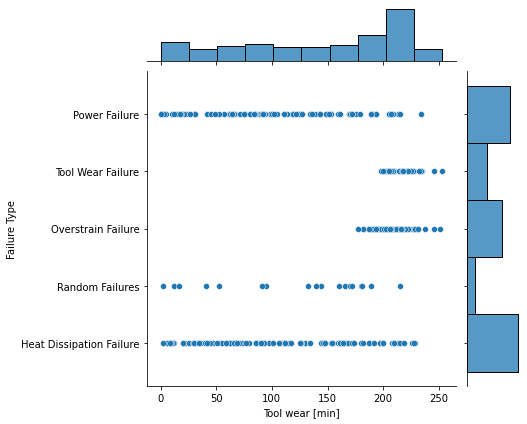

In [75]:
for col in df_type.drop(columns = 'Failure Type'):
    
    sns.jointplot(data=df_type, x=col, y='Failure Type')

## Construíndo Modelos

Para esse caso, é mais importante identificar corretamente os tipos de erro, sendo assim, será utilizado como métrica de comparação a Acurácia.

In [76]:
X = df_type.drop(columns = 'Failure Type')
y = df_type['Failure Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Criando Função para exibir as métricas de classificação

In [77]:
def exibir_metricas(y_train, y_pred_train, y_test, y_pred_test):
    print("\nMétricas de avaliação de treino:")

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    print("\n# =======================================================\n")

    print("\nMétricas de avaliação de teste:")

    print(confusion_matrix(y_test, y_pred_test))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

### Regressão Logística

In [78]:
lista_etapas_lr = [("std_scaler", StandardScaler()), 
                   ("poly", PolynomialFeatures()),
                   ("lr", LogisticRegression(max_iter = 1000))]

pipeline_lr = Pipeline(lista_etapas_lr)

cv_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_lr = make_scorer(accuracy_score)

param_grid_lr = {"lr__solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              "poly__degree": range(2,4)}

#verbose=10 pra muitas combinações, os prints vão pro terminal
rando_lr = RandomizedSearchCV(estimator = pipeline_lr, 
                              param_distributions = param_grid_lr,
                              scoring = scoring_lr,
                              cv = cv_lr,
                              verbose = 10,
                              n_iter = 10)

rando_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START lr__solver=newton-cg, poly__degree=3.......................
[CV 1/5; 1/10] END lr__solver=newton-cg, poly__degree=3;, score=0.929 total time=   0.0s
[CV 2/5; 1/10] START lr__solver=newton-cg, poly__degree=3.......................
[CV 2/5; 1/10] END lr__solver=newton-cg, poly__degree=3;, score=0.893 total time=   0.0s
[CV 3/5; 1/10] START lr__solver=newton-cg, poly__degree=3.......................
[CV 3/5; 1/10] END lr__solver=newton-cg, poly__degree=3;, score=0.804 total time=   0.0s
[CV 4/5; 1/10] START lr__solver=newton-cg, poly__degree=3.......................
[CV 4/5; 1/10] END lr__solver=newton-cg, poly__degree=3;, score=0.927 total time=   0.0s
[CV 5/5; 1/10] START lr__solver=newton-cg, poly__degree=3.......................
[CV 5/5; 1/10] END lr__solver=newton-cg, poly__degree=3;, score=0.873 total time=   0.0s
[CV 1/5; 2/10] START lr__solver=liblinear, poly__degree=2.......................
[CV 1/5;

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('poly', PolynomialFeatures()),
                                             ('lr',
                                              LogisticRegression(max_iter=1000))]),
                   param_distributions={'lr__solver': ['lbfgs', 'liblinear',
                                                       'newton-cg',
                                                       'newton-cholesky', 'sag',
                                                       'saga'],
                                        'poly__degree': range(2, 4)},
                   scoring=make_scorer(accuracy_score), verbose=10)

In [79]:
print('Melhores Parâmetros:')
print(rando_lr.best_params_)
print('Melhor Métrica Média:')
print(rando_lr.best_score_)

Melhores Parâmetros:
{'poly__degree': 3, 'lr__solver': 'newton-cg'}
Melhor Métrica Média:
0.885



Métricas de avaliação de treino:


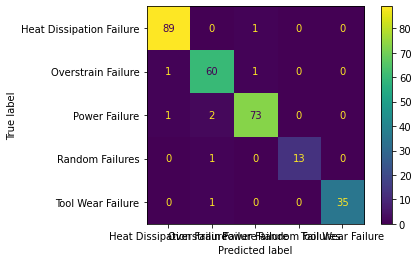

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.98      0.99      0.98        90
      Overstrain Failure       0.94      0.97      0.95        62
           Power Failure       0.97      0.96      0.97        76
         Random Failures       1.00      0.93      0.96        14
       Tool Wear Failure       1.00      0.97      0.99        36

                accuracy                           0.97       278
               macro avg       0.98      0.96      0.97       278
            weighted avg       0.97      0.97      0.97       278


# =======================================================


Métricas de avaliação de teste:
[[22  0  0  0  0]
 [ 2 12  2  0  0]
 [ 1  0 18  0  0]
 [ 0  0  1  2  1]
 [ 0  1  0  1  7]]


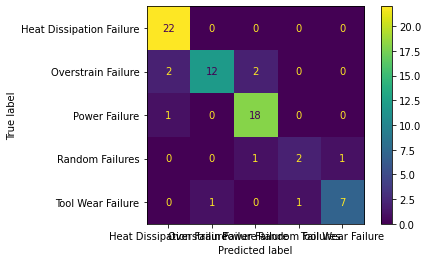

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.88      1.00      0.94        22
      Overstrain Failure       0.92      0.75      0.83        16
           Power Failure       0.86      0.95      0.90        19
         Random Failures       0.67      0.50      0.57         4
       Tool Wear Failure       0.88      0.78      0.82         9

                accuracy                           0.87        70
               macro avg       0.84      0.80      0.81        70
            weighted avg       0.87      0.87      0.87        70



In [80]:
y_pred_test = rando_lr.predict(X_test)
y_pred_train = rando_lr.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Utilizando métodos de classificação

### KNN

In [81]:
lista_etapas_knn = [('scaler', StandardScaler()), 
                    ('knn', KNeighborsClassifier())]
pipeline_knn = Pipeline(lista_etapas_knn)

cv_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

scoring_knn = make_scorer(accuracy_score)

param_grid_knn = {"knn__weights" : ["distance", "uniform"],
                  "knn__metric" : ["manhattan", "euclidean", "minkowski"],
                  "knn__n_neighbors" : range(3, 20)}

grid_knn = GridSearchCV(estimator = pipeline_knn, 
                        param_grid = param_grid_knn,
                        scoring = scoring_knn,
                        cv = cv_knn,
                        verbose = 10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 102 candidates, totalling 1020 fits
[CV 1/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 1/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.893 total time=   0.0s
[CV 2/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 2/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 3/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 3/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.893 total time=   0.0s
[CV 4/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 4/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.821 total time=   0.0s
[CV 5/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 5/10; 1/102] EN

[CV 3/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.821 total time=   0.0s
[CV 4/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 4/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.821 total time=   0.0s
[CV 5/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 5/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.679 total time=   0.0s
[CV 6/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 6/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.893 total time=   0.0s
[CV 7/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 7/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.821 total time=   0.0s
[CV 8/10; 5/102] START knn__metric=manhattan, knn__n_

[CV 8/10; 11/102] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 9/10; 11/102] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 9/10; 11/102] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.852 total time=   0.0s
[CV 10/10; 11/102] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 10/10; 11/102] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.778 total time=   0.0s
[CV 1/10; 12/102] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 1/10; 12/102] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 2/10; 12/102] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 2/10; 12/102] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 3/10; 12/102] START knn__metric=manhattan,

[CV 5/10; 16/102] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=0.786 total time=   0.0s
[CV 6/10; 16/102] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 6/10; 16/102] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=0.786 total time=   0.0s
[CV 7/10; 16/102] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 7/10; 16/102] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 8/10; 16/102] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 8/10; 16/102] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 9/10; 16/102] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 9/10; 16/102] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=0.815 total time=   0.0s
[CV 10/10; 16/102] START knn__metric=manhatt

[CV 9/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.815 total time=   0.0s
[CV 10/10; 22/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 10/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10; 23/102] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 1/10; 23/102] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=0.857 total time=   0.0s
[CV 2/10; 23/102] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 2/10; 23/102] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 3/10; 23/102] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 3/10; 23/102] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=0.714 total time=   0.0s
[CV 4/10; 23/102] START knn__metric=

[CV 5/10; 27/102] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 6/10; 27/102] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 6/10; 27/102] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 7/10; 27/102] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 7/10; 27/102] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 8/10; 27/102] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 8/10; 27/102] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 9/10; 27/102] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 9/10; 27/102] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.852 total time=   0.0s
[CV 10/10; 27/102] START knn__metri

[CV 10/10; 33/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.815 total time=   0.0s
[CV 1/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 1/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 2/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 2/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 3/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 3/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 4/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 4/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10; 34/102] START knn__metric=manhat

[CV 6/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 7/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 7/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 8/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 8/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.786 total time=   0.0s
[CV 9/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 9/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10; 38/102] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 10/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.741 total time=   0.0s
[CV 1/10; 39/102] START knn__metric=euclidean, knn_

[CV 1/10; 45/102] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.893 total time=   0.0s
[CV 2/10; 45/102] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 2/10; 45/102] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 3/10; 45/102] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 3/10; 45/102] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.857 total time=   0.0s
[CV 4/10; 45/102] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 4/10; 45/102] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 5/10; 45/102] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 5/10; 45/102] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.714 total time=   0.0s
[CV 6/10; 45/102] START knn__metric=euclidea

[CV 8/10; 49/102] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 9/10; 49/102] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance
[CV 9/10; 49/102] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance;, score=0.852 total time=   0.0s
[CV 10/10; 49/102] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance
[CV 10/10; 49/102] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=distance;, score=0.741 total time=   0.0s
[CV 1/10; 50/102] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform
[CV 1/10; 50/102] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 2/10; 50/102] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform
[CV 2/10; 50/102] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 3/10; 50/102] START knn__metric=e

[CV 3/10; 56/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.714 total time=   0.0s
[CV 4/10; 56/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 4/10; 56/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 5/10; 56/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 5/10; 56/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 6/10; 56/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 6/10; 56/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.786 total time=   0.0s
[CV 7/10; 56/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 7/10; 56/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 8/10; 56/102] START knn__metric=euclidea

[CV 10/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10; 61/102] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance
[CV 1/10; 61/102] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance;, score=0.893 total time=   0.0s
[CV 2/10; 61/102] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance
[CV 2/10; 61/102] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 3/10; 61/102] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance
[CV 3/10; 61/102] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance;, score=0.714 total time=   0.0s
[CV 4/10; 61/102] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance
[CV 4/10; 61/102] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 5/10; 61/102] START knn__metric

[CV 5/10; 67/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 6/10; 67/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 6/10; 67/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 7/10; 67/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 7/10; 67/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.714 total time=   0.0s
[CV 8/10; 67/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 8/10; 67/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.679 total time=   0.0s
[CV 9/10; 67/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 9/10; 67/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.852 total time=   0.0s
[CV 10/10; 67/102] START knn__metri

[CV 1/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.893 total time=   0.0s
[CV 2/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 2/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 3/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 4/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 5/10; 72/102] START knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.679 total time=   0.0s
[CV 6/10; 72/102] START knn__metric=minkowski, knn__n

[CV 6/10; 78/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform;, score=0.786 total time=   0.0s
[CV 7/10; 78/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform
[CV 7/10; 78/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform;, score=0.714 total time=   0.0s
[CV 8/10; 78/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform
[CV 8/10; 78/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 9/10; 78/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform
[CV 9/10; 78/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10; 78/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform
[CV 10/10; 78/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10; 79/102] START knn__metric=minkowski, knn_

[CV 2/10; 83/102] END knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 3/10; 83/102] START knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance
[CV 3/10; 83/102] END knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 4/10; 83/102] START knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance
[CV 4/10; 83/102] END knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance;, score=0.714 total time=   0.0s
[CV 5/10; 83/102] START knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance
[CV 5/10; 83/102] END knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance;, score=0.643 total time=   0.0s
[CV 6/10; 83/102] START knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance
[CV 6/10; 83/102] END knn__metric=minkowski, knn__n_neighbors=10, knn__weights=distance;, score=0.786 total time=   0.0s
[CV 7/10; 83/102] START knn__metric

[CV 8/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.679 total time=   0.0s
[CV 9/10; 89/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance
[CV 9/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.852 total time=   0.0s
[CV 10/10; 89/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance
[CV 10/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.741 total time=   0.0s
[CV 1/10; 90/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform
[CV 1/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.786 total time=   0.0s
[CV 2/10; 90/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform
[CV 2/10; 90/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=uniform;, score=0.750 total time=   0.0s
[CV 3/10; 90/102] START knn__metric=m

[CV 4/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.714 total time=   0.0s
[CV 5/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 5/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.714 total time=   0.0s
[CV 6/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 6/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.821 total time=   0.0s
[CV 7/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 7/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.714 total time=   0.0s
[CV 8/10; 94/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform
[CV 8/10; 94/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=uniform;, score=0.643 total time=   0.0s
[CV 9/10; 94/102] START knn__metric=minkowsk

[CV 9/10; 100/102] END knn__metric=minkowski, knn__n_neighbors=18, knn__weights=uniform;, score=0.815 total time=   0.0s
[CV 10/10; 100/102] START knn__metric=minkowski, knn__n_neighbors=18, knn__weights=uniform
[CV 10/10; 100/102] END knn__metric=minkowski, knn__n_neighbors=18, knn__weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10; 101/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=distance
[CV 1/10; 101/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=distance;, score=0.857 total time=   0.0s
[CV 2/10; 101/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=distance
[CV 2/10; 101/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=distance;, score=0.750 total time=   0.0s
[CV 3/10; 101/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=distance
[CV 3/10; 101/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=distance;, score=0.714 total time=   0.0s
[CV 4/10; 101/102] START kn

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean', 'minkowski'],
                         'knn__n_neighbors': range(3, 20),
                         'knn__weights': ['distance', 'uniform']},
             scoring=make_scorer(accuracy_score), verbose=10)

In [82]:
print('Melhores Parâmetros:')
print(grid_knn.best_params_)
print('Melhor Métrica Média:')
print(grid_knn.best_score_)

Melhores Parâmetros:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Melhor Métrica Média:
0.8242063492063492



Métricas de avaliação de treino:


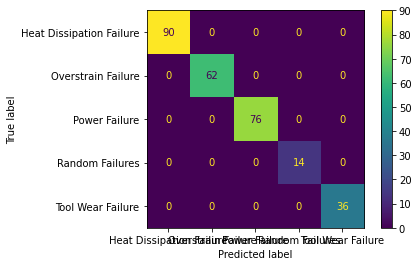

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        90
      Overstrain Failure       1.00      1.00      1.00        62
           Power Failure       1.00      1.00      1.00        76
         Random Failures       1.00      1.00      1.00        14
       Tool Wear Failure       1.00      1.00      1.00        36

                accuracy                           1.00       278
               macro avg       1.00      1.00      1.00       278
            weighted avg       1.00      1.00      1.00       278


# =======================================================


Métricas de avaliação de teste:
[[22  0  0  0  0]
 [ 1 13  2  0  0]
 [ 5  1 13  0  0]
 [ 1  0  1  0  2]
 [ 1  0  1  2  5]]


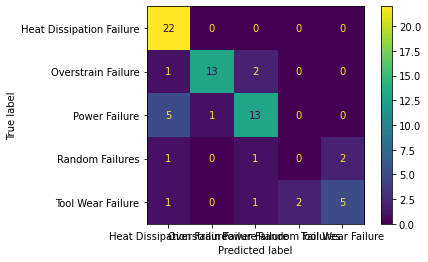

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.73      1.00      0.85        22
      Overstrain Failure       0.93      0.81      0.87        16
           Power Failure       0.76      0.68      0.72        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.71      0.56      0.63         9

                accuracy                           0.76        70
               macro avg       0.63      0.61      0.61        70
            weighted avg       0.74      0.76      0.74        70



In [83]:
y_pred_test = grid_knn.predict(X_test)
y_pred_train = grid_knn.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

### Árvore de Decisões

In [84]:
lista_etapas_dt = [('scaler', StandardScaler()), 
                   ("dt", DecisionTreeClassifier(random_state=42))]
pipeline_dt = Pipeline(lista_etapas_dt)

cv_dt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_dt = make_scorer(accuracy_score)

params_grid_dt = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 11)} 

grid_dt = GridSearchCV(estimator = pipeline_dt, 
                        param_grid = params_grid_dt,
                        scoring = scoring_dt,
                        cv = cv_dt,
                        verbose=10)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 1/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.661 total time=   0.0s
[CV 2/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 2/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.607 total time=   0.0s
[CV 3/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 3/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.732 total time=   0.0s
[CV 4/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 4/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.836 total time=   0.0s
[CV 5/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 5/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.818 total time=   0.0

[CV 2/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.857 total time=   0.0s
[CV 3/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 3/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.696 total time=   0.0s
[CV 4/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 4/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.873 total time=   0.0s
[CV 5/5; 10/36] START dt__criterion=gini, dt__max_depth=6, dt__splitter=random..
[CV 5/5; 10/36] END dt__criterion=gini, dt__max_depth=6, dt__splitter=random;, score=0.800 total time=   0.0s
[CV 1/5; 11/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=best....
[CV 1/5; 11/36] END dt__criterion=gini, dt__max_depth=7, dt__splitter=best;, score=0.893 total time=   0.0s
[CV 2/5; 11/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=best....
[CV 2/5; 11/36] END dt__criterion=gini, dt__max

[CV 5/5; 23/36] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=best;, score=0.818 total time=   0.0s
[CV 1/5; 24/36] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=random
[CV 1/5; 24/36] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=random;, score=0.857 total time=   0.0s
[CV 2/5; 24/36] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=random
[CV 2/5; 24/36] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=random;, score=0.786 total time=   0.0s
[CV 3/5; 24/36] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=random
[CV 3/5; 24/36] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=random;, score=0.643 total time=   0.0s
[CV 4/5; 24/36] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=random
[CV 4/5; 24/36] END dt__criterion=entropy, dt__max_depth=4, dt__splitter=random;, score=0.782 total time=   0.0s
[CV 5/5; 24/36] START dt__criterion=entropy, dt__max_depth=4, dt__splitter=random
[CV 5/5; 24/36] END dt__cri

[CV 1/5; 33/36] END dt__criterion=entropy, dt__max_depth=9, dt__splitter=best;, score=0.893 total time=   0.0s
[CV 2/5; 33/36] START dt__criterion=entropy, dt__max_depth=9, dt__splitter=best.
[CV 2/5; 33/36] END dt__criterion=entropy, dt__max_depth=9, dt__splitter=best;, score=0.786 total time=   0.0s
[CV 3/5; 33/36] START dt__criterion=entropy, dt__max_depth=9, dt__splitter=best.
[CV 3/5; 33/36] END dt__criterion=entropy, dt__max_depth=9, dt__splitter=best;, score=0.804 total time=   0.0s
[CV 4/5; 33/36] START dt__criterion=entropy, dt__max_depth=9, dt__splitter=best.
[CV 4/5; 33/36] END dt__criterion=entropy, dt__max_depth=9, dt__splitter=best;, score=0.909 total time=   0.0s
[CV 5/5; 33/36] START dt__criterion=entropy, dt__max_depth=9, dt__splitter=best.
[CV 5/5; 33/36] END dt__criterion=entropy, dt__max_depth=9, dt__splitter=best;, score=0.764 total time=   0.0s
[CV 1/5; 34/36] START dt__criterion=entropy, dt__max_depth=9, dt__splitter=random
[CV 1/5; 34/36] END dt__criterion=entro

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random']},
             scoring=make_scorer(accuracy_score), verbose=10)

In [85]:
print('Melhores Parâmetros:')
print(grid_dt.best_params_)
print('Melhor Métrica Média:')
print(grid_dt.best_score_)

Melhores Parâmetros:
{'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__splitter': 'best'}
Melhor Métrica Média:
0.849025974025974



Métricas de avaliação de treino:


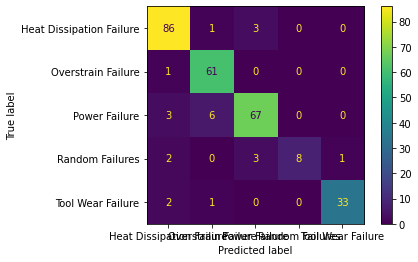

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.91      0.96      0.93        90
      Overstrain Failure       0.88      0.98      0.93        62
           Power Failure       0.92      0.88      0.90        76
         Random Failures       1.00      0.57      0.73        14
       Tool Wear Failure       0.97      0.92      0.94        36

                accuracy                           0.92       278
               macro avg       0.94      0.86      0.89       278
            weighted avg       0.92      0.92      0.91       278


# =======================================================


Métricas de avaliação de teste:
[[22  0  0  0  0]
 [ 3 10  2  0  1]
 [ 0  1 18  0  0]
 [ 1  0  0  2  1]
 [ 0  1  0  0  8]]


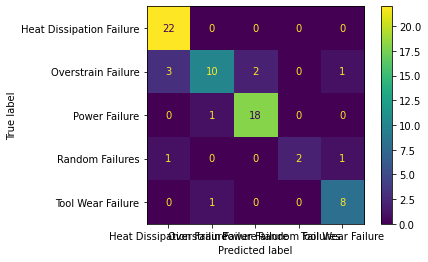

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.85      1.00      0.92        22
      Overstrain Failure       0.83      0.62      0.71        16
           Power Failure       0.90      0.95      0.92        19
         Random Failures       1.00      0.50      0.67         4
       Tool Wear Failure       0.80      0.89      0.84         9

                accuracy                           0.86        70
               macro avg       0.88      0.79      0.81        70
            weighted avg       0.86      0.86      0.85        70



In [86]:
y_pred_test = grid_dt.predict(X_test)
y_pred_train = grid_dt.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Utilizando métodos de Ensemble

### Random Forest

In [87]:
lista_etapas_rf = [("std_scaler", StandardScaler()), 
                   ("rf", RandomForestClassifier(n_jobs=-1))]

pipeline_rf = Pipeline(lista_etapas_rf)

cv_rf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


scoring_rf = make_scorer(accuracy_score)


param_grid_rf = {"rf__n_estimators" : range(100, 600, 100),
                 "rf__max_depth" : range(3, 6),
                 "rf__max_features" : ['sqrt', 'log2'],
                 "rf__criterion" : ['entropy', 'gini']}

grid_rf = GridSearchCV(estimator = pipeline_rf, 
                        param_grid = param_grid_rf,
                        scoring = scoring_rf,
                        cv = cv_rf,
                        verbose = 10)


grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 1/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.821 total time=   0.0s
[CV 2/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 2/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.786 total time=   0.0s
[CV 3/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 3/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.750 total time=   0.0s
[CV 4/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 4/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10

[CV 4/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.786 total time=   0.1s
[CV 5/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 5/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.857 total time=   0.1s
[CV 6/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 6/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.893 total time=   0.1s
[CV 7/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 7/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.786 total time=   0.1s
[CV 8/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 8/10; 4/60] END rf__crit

[CV 8/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.821 total time=   0.0s
[CV 9/10; 7/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200
[CV 9/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.889 total time=   0.0s
[CV 10/10; 7/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200
[CV 10/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.815 total time=   0.0s
[CV 1/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 1/10; 8/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.821 total time=   0.1s
[CV 2/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 2/10; 8/60] END rf__cr

[CV 3/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.821 total time=   0.0s
[CV 4/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 4/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.786 total time=   0.0s
[CV 5/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 5/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.821 total time=   0.0s
[CV 6/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 6/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.893 total time=   0.0s
[CV 7/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 7/10; 11/60] END

[CV 7/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.857 total time=   0.1s
[CV 8/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 8/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.821 total time=   0.1s
[CV 9/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 9/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.889 total time=   0.1s
[CV 10/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 10/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.852 total time=   0.1s
[CV 1/10; 15/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500
[CV 1/10; 15/60] E

[CV 1/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.964 total time=   0.1s
[CV 2/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 2/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.893 total time=   0.1s
[CV 3/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 3/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.786 total time=   0.1s
[CV 4/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 4/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.714 total time=   0.1s
[CV 5/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 5/10; 18/60] END

[CV 6/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.964 total time=   0.0s
[CV 7/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 7/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.893 total time=   0.0s
[CV 8/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 8/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.857 total time=   0.0s
[CV 9/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 9/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.852 total time=   0.0s
[CV 10/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 10/10; 21/60] E

[CV 10/10; 24/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=400;, score=0.889 total time=   0.1s
[CV 1/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 1/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.964 total time=   0.2s
[CV 2/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 2/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.929 total time=   0.2s
[CV 3/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 3/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.821 total time=   0.2s
[CV 4/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 4/10; 25/60] EN

[CV 5/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.857 total time=   0.1s
[CV 6/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 6/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.929 total time=   0.1s
[CV 7/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 7/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.929 total time=   0.1s
[CV 8/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 8/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.857 total time=   0.1s
[CV 9/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 9/10; 28/60] END

[CV 9/10; 31/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.926 total time=   0.0s
[CV 10/10; 31/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 10/10; 31/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.852 total time=   0.0s
[CV 1/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 1/10; 32/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200;, score=0.857 total time=   0.0s
[CV 2/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 2/10; 32/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200;, score=0.786 total time=   0.0s
[CV 3/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 3/10; 32/60] END rf__criterion=gini, r

[CV 4/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.714 total time=   0.2s
[CV 5/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 5/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.821 total time=   0.2s
[CV 6/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 6/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.929 total time=   0.2s
[CV 7/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 7/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.821 total time=   0.2s
[CV 8/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 8/10; 35/60] END rf__criterion=gini, rf_

[CV 9/10; 38/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.889 total time=   0.1s
[CV 10/10; 38/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 10/10; 38/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.852 total time=   0.1s
[CV 1/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 1/10; 39/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400;, score=0.893 total time=   0.1s
[CV 2/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 2/10; 39/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400;, score=0.786 total time=   0.1s
[CV 3/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 3/10; 39/60] END rf__criterion=gini, r

[CV 5/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.821 total time=   0.0s
[CV 6/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 6/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.929 total time=   0.0s
[CV 7/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 7/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.786 total time=   0.0s
[CV 8/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 8/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.857 total time=   0.0s
[CV 9/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 9/10; 42/60] END rf__criterion=gini, rf_

[CV 10/10; 45/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500;, score=0.815 total time=   0.2s
[CV 1/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 1/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.929 total time=   0.0s
[CV 2/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 2/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.857 total time=   0.0s
[CV 3/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 3/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.821 total time=   0.0s
[CV 4/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 4/10; 46/60] END rf__criterion=gini, rf

[CV 5/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.857 total time=   0.1s
[CV 6/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 6/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.929 total time=   0.1s
[CV 7/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 7/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.786 total time=   0.1s
[CV 8/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 8/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.893 total time=   0.1s
[CV 9/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 9/10; 49/60] END rf__criterion=gini, rf_

[CV 1/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.964 total time=   0.1s
[CV 2/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 2/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.929 total time=   0.1s
[CV 3/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 3/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.857 total time=   0.1s
[CV 4/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 4/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.786 total time=   0.1s
[CV 5/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 5/10; 53/60] END rf__criterion=gini, rf_

[CV 6/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.929 total time=   0.0s
[CV 7/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 7/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.821 total time=   0.0s
[CV 8/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 8/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.893 total time=   0.0s
[CV 9/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 9/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.889 total time=   0.0s
[CV 10/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 10/10; 56/60] END rf__criterion=gini, r

[CV 1/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.964 total time=   0.2s
[CV 2/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 2/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.929 total time=   0.2s
[CV 3/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 3/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.857 total time=   0.2s
[CV 4/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 4/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.750 total time=   0.2s
[CV 5/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 5/10; 60/60] END rf__criterion=gini, rf_

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rf__criterion': ['entropy', 'gini'],
                         'rf__max_depth': range(3, 6),
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': range(100, 600, 100)},
             scoring=make_scorer(accuracy_score), verbose=10)

In [88]:
print('Melhores Parâmetros:')
print(grid_rf.best_params_)
print('Melhor Métrica Média:')
print(grid_rf.best_score_)

Melhores Parâmetros:
{'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Melhor Métrica Média:
0.8920634920634921



Métricas de avaliação de treino:


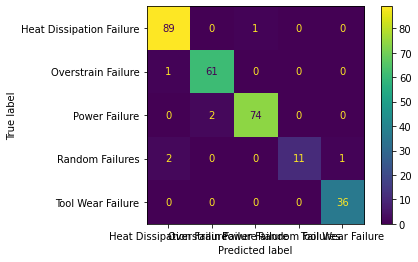

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.97      0.99      0.98        90
      Overstrain Failure       0.97      0.98      0.98        62
           Power Failure       0.99      0.97      0.98        76
         Random Failures       1.00      0.79      0.88        14
       Tool Wear Failure       0.97      1.00      0.99        36

                accuracy                           0.97       278
               macro avg       0.98      0.95      0.96       278
            weighted avg       0.98      0.97      0.97       278


# =======================================================


Métricas de avaliação de teste:
[[22  0  0  0  0]
 [ 3 10  2  0  1]
 [ 0  1 18  0  0]
 [ 1  0  0  2  1]
 [ 0  1  0  0  8]]


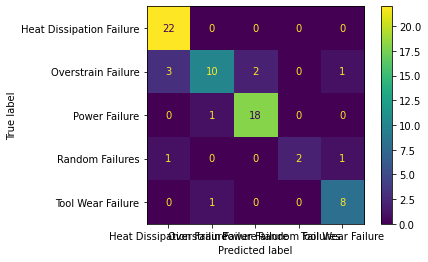

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.85      1.00      0.92        22
      Overstrain Failure       0.83      0.62      0.71        16
           Power Failure       0.90      0.95      0.92        19
         Random Failures       1.00      0.50      0.67         4
       Tool Wear Failure       0.80      0.89      0.84         9

                accuracy                           0.86        70
               macro avg       0.88      0.79      0.81        70
            weighted avg       0.86      0.86      0.85        70



In [89]:
y_pred_test = grid_rf.predict(X_test)
y_pred_train = grid_rf.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

### AdaBoost

In [90]:
lista_etapas_ab = [("std_scaler", StandardScaler()), 
                   ("ab", AdaBoostClassifier())]

pipeline_ab = Pipeline(lista_etapas_ab)

cv_ab = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


scoring_ab = make_scorer(accuracy_score)


param_grid_ab = {"ab__n_estimators" : range(25, 100, 10)}

grid_ab = GridSearchCV(estimator = pipeline_ab, 
                        param_grid = param_grid_ab,
                        scoring = scoring_ab,
                        cv = cv_ab,
                        verbose = 10)


grid_ab.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START ab__n_estimators=25........................................
[CV 1/10; 1/8] END .........ab__n_estimators=25;, score=0.643 total time=   0.0s
[CV 2/10; 1/8] START ab__n_estimators=25........................................
[CV 2/10; 1/8] END .........ab__n_estimators=25;, score=0.607 total time=   0.0s
[CV 3/10; 1/8] START ab__n_estimators=25........................................
[CV 3/10; 1/8] END .........ab__n_estimators=25;, score=0.536 total time=   0.0s
[CV 4/10; 1/8] START ab__n_estimators=25........................................
[CV 4/10; 1/8] END .........ab__n_estimators=25;, score=0.571 total time=   0.0s
[CV 5/10; 1/8] START ab__n_estimators=25........................................
[CV 5/10; 1/8] END .........ab__n_estimators=25;, score=0.571 total time=   0.0s
[CV 6/10; 1/8] START ab__n_estimators=25........................................
[CV 6/10; 1/8] END .........ab__n_estimators=25;

[CV 1/10; 6/8] END .........ab__n_estimators=75;, score=0.643 total time=   0.0s
[CV 2/10; 6/8] START ab__n_estimators=75........................................
[CV 2/10; 6/8] END .........ab__n_estimators=75;, score=0.607 total time=   0.0s
[CV 3/10; 6/8] START ab__n_estimators=75........................................
[CV 3/10; 6/8] END .........ab__n_estimators=75;, score=0.536 total time=   0.0s
[CV 4/10; 6/8] START ab__n_estimators=75........................................
[CV 4/10; 6/8] END .........ab__n_estimators=75;, score=0.571 total time=   0.0s
[CV 5/10; 6/8] START ab__n_estimators=75........................................
[CV 5/10; 6/8] END .........ab__n_estimators=75;, score=0.571 total time=   0.0s
[CV 6/10; 6/8] START ab__n_estimators=75........................................
[CV 6/10; 6/8] END .........ab__n_estimators=75;, score=0.536 total time=   0.0s
[CV 7/10; 6/8] START ab__n_estimators=75........................................
[CV 7/10; 6/8] END .........

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('ab', AdaBoostClassifier())]),
             param_grid={'ab__n_estimators': range(25, 100, 10)},
             scoring=make_scorer(accuracy_score), verbose=10)

In [91]:
print('Melhores Parâmetros:')
print(grid_ab.best_params_)
print('Melhor Métrica Média:')
print(grid_ab.best_score_)

Melhores Parâmetros:
{'ab__n_estimators': 35}
Melhor Métrica Média:
0.5755291005291006



Métricas de avaliação de treino:


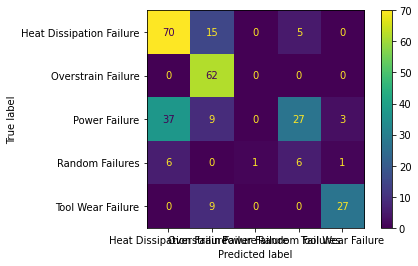

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.62      0.78      0.69        90
      Overstrain Failure       0.65      1.00      0.79        62
           Power Failure       0.00      0.00      0.00        76
         Random Failures       0.16      0.43      0.23        14
       Tool Wear Failure       0.87      0.75      0.81        36

                accuracy                           0.59       278
               macro avg       0.46      0.59      0.50       278
            weighted avg       0.47      0.59      0.52       278


# =======================================================


Métricas de avaliação de teste:
[[18  1  0  2  1]
 [ 2 14  0  0  0]
 [10  1  0  8  0]
 [ 1  0  0  2  1]
 [ 0  2  0  0  7]]


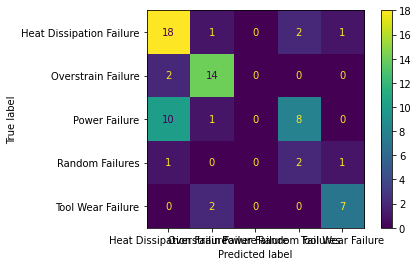

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.58      0.82      0.68        22
      Overstrain Failure       0.78      0.88      0.82        16
           Power Failure       0.00      0.00      0.00        19
         Random Failures       0.17      0.50      0.25         4
       Tool Wear Failure       0.78      0.78      0.78         9

                accuracy                           0.59        70
               macro avg       0.46      0.59      0.51        70
            weighted avg       0.47      0.59      0.52        70



In [92]:
y_pred_test = grid_ab.predict(X_test)
y_pred_train = grid_ab.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Resultado do Teste 1 Parte 2:

após fazer a predição utilizando de cinco modelos diferentes temos um ranking de acurácia:

- 1º - Regressão Logistica - 0.87
- 2º - Árvore de Decisões - 0.86
- 3º - Random Forest - 0.84
- 4º - Knn - 0.76
- 5º - AdaBoost - 0.59

## Segundo Teste

In [93]:
df_final = df_mp.drop(columns = 'Target')
df_final

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                         
1         1                298.1                    308.6   
2         0                298.2                    308.7   
3         0                298.1                    308.5   
4         0                298.2                    308.6   
5         0                298.2                    308.7   
...     ...                  ...                      ...   
9996      1                298.8                    308.4   
9997      2                298.9                    308.4   
9998      1                299.0                    308.6   
9999      2                299.0                    308.7   
10000     1                299.0                    308.7   

       Rotational speed [rpm]  Torque [Nm]  Tool wear [min] Failure Type  
UDI                                                                       
1                        1551         42.8                0   No Failure  
2                        1408         46.3                3   No Failure  
3                        1498         49.4                5   No Failure  
4                        1433         39.5                7   No Failure  
5                        1408         40.0                9   No Failure  
...                       ...          ...              ...          ...  
9996                     1604         29.5               14   No Failure  
9997                     1632         31.8               17   No Failure  
9998                     1645         33.4               22   No Failure  
9999                     1408         48.5               25   No Failure  
10000                    1500         40.2               30   No Failure  

[10000 rows x 7 columns]

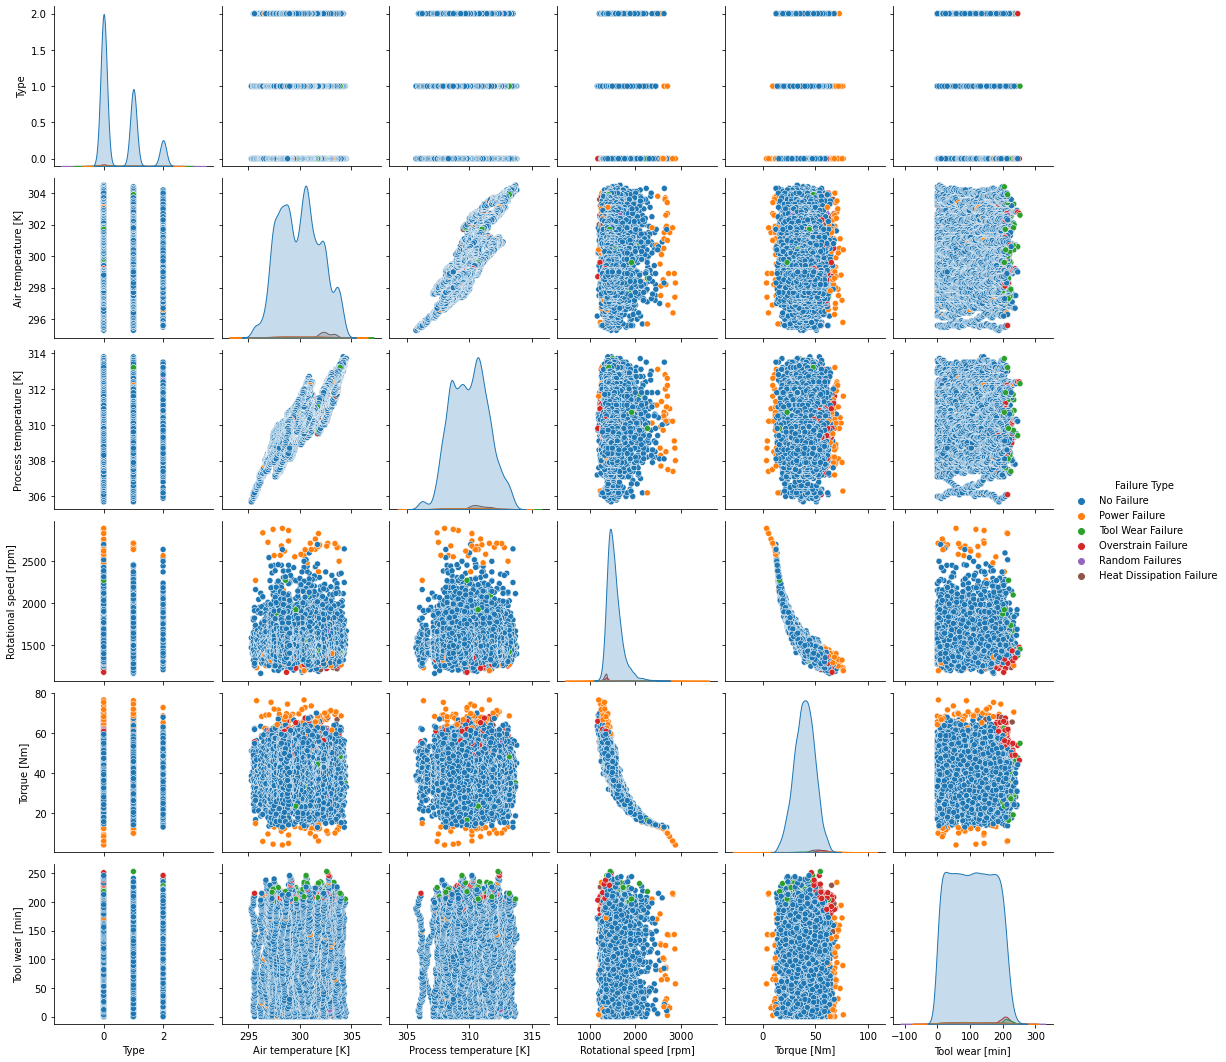

In [94]:
sns.pairplot(df_final, hue = 'Failure Type')

In [95]:
df_dummies_final = pd.get_dummies(df_final, columns = ['Failure Type'])
df_dummies_final.head(2)

Type  Air temperature [K]  Process temperature [K]  \
UDI                                                       
1       1                298.1                    308.6   
2       0                298.2                    308.7   

     Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  \
UDI                                                         
1                      1551         42.8                0   
2                      1408         46.3                3   

     Failure Type_Heat Dissipation Failure  Failure Type_No Failure  \
UDI                                                                   
1                                        0                        1   
2                                        0                        1   

     Failure Type_Overstrain Failure  Failure Type_Power Failure  \
UDI                                                                
1                                  0                           0   
2                                  0                           0   

     Failure Type_Random Failures  Failure Type_Tool Wear Failure  
UDI                                                                
1                               0                               0  
2                               0                               0

Checando a Correlação das features com a o Tipo de falha No failure

##### Pearson

In [96]:
df_dummies_final.corr()

Type  Air temperature [K]  \
Type                                   1.000000            -0.015176   
Air temperature [K]                   -0.015176             1.000000   
Process temperature [K]               -0.012101             0.876107   
Rotational speed [rpm]                -0.003979             0.022670   
Torque [Nm]                           -0.003097            -0.013778   
Tool wear [min]                       -0.007255             0.013853   
Failure Type_Heat Dissipation Failure -0.014204             0.136372   
Failure Type_No Failure                0.036663            -0.084453   
Failure Type_Overstrain Failure       -0.055922            -0.006072   
Failure Type_Power Failure            -0.010026             0.003470   
Failure Type_Random Failures           0.003495             0.016172   
Failure Type_Tool Wear Failure         0.007760             0.009545   

                                       Process temperature [K]  \
Type                                                 -0.012101   
Air temperature [K]                                   0.876107   
Process temperature [K]                               1.000000   
Rotational speed [rpm]                                0.019277   
Torque [Nm]                                          -0.014061   
Tool wear [min]                                       0.013488   
Failure Type_Heat Dissipation Failure                 0.056924   
Failure Type_No Failure                              -0.039816   
Failure Type_Overstrain Failure                       0.002732   
Failure Type_Power Failure                           -0.003355   
Failure Type_Random Failures                          0.021466   
Failure Type_Tool Wear Failure                        0.007200   

                                       Rotational speed [rpm]  Torque [Nm]  \
Type                                                -0.003979    -0.003097   
Air temperature [K]                                  0.022670    -0.013778   
Process temperature [K]                              0.019277    -0.014061   
Rotational speed [rpm]                               1.000000    -0.875027   
Torque [Nm]                                         -0.875027     1.000000   
Tool wear [min]                                      0.000223    -0.003093   
Failure Type_Heat Dissipation Failure               -0.119213     0.136570   
Failure Type_No Failure                              0.045483    -0.191563   
Failure Type_Overstrain Failure                     -0.091264     0.150239   
Failure Type_Power Failure                           0.123018     0.083781   
Failure Type_Random Failures                        -0.011685     0.015060   
Failure Type_Tool Wear Failure                       0.011960    -0.018617   

                                       Tool wear [min]  \
Type                                         -0.007255   
Air temperature [K]                           0.013853   
Process temperature [K]                       0.013488   
Rotational speed [rpm]                        0.000223   
Torque [Nm]                                  -0.003093   
Tool wear [min]                               1.000000   
Failure Type_Heat Dissipation Failure        -0.001023   
Failure Type_No Failure                      -0.105251   
Failure Type_Overstrain Failure               0.139669   
Failure Type_Power Failure                   -0.009334   
Failure Type_Random Failures                  0.007964   
Failure Type_Tool Wear Failure                0.114717   

                                       Failure Type_Heat Dissipation Failure  \
Type                                                               -0.014204   
Air temperature [K]                                                 0.136372   
Process temperature [K]                                             0.056924   
Rotational speed [rpm]                                             -0.119213   
Torque [Nm]                                                         0.136570 

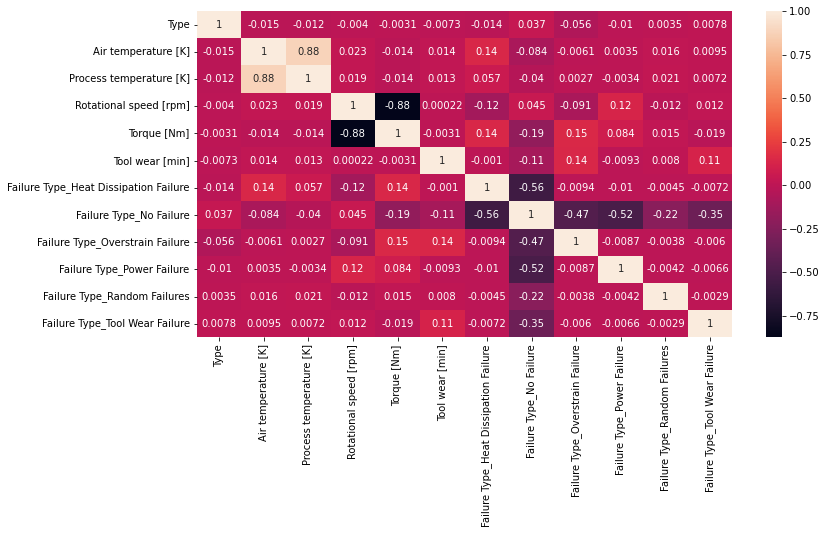

In [97]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_dummies_final.corr(), annot=True);

##### Spearman

In [98]:
df_dummies_final.corr('spearman')

Type  Air temperature [K]  \
Type                                   1.000000            -0.013100   
Air temperature [K]                   -0.013100             1.000000   
Process temperature [K]               -0.009577             0.864217   
Rotational speed [rpm]                -0.003921             0.013732   
Torque [Nm]                           -0.000167            -0.011765   
Tool wear [min]                       -0.007548             0.013495   
Failure Type_Heat Dissipation Failure -0.014029             0.136423   
Failure Type_No Failure                0.038184            -0.085524   
Failure Type_Overstrain Failure       -0.059554            -0.005394   
Failure Type_Power Failure            -0.007415             0.004867   
Failure Type_Random Failures          -0.000948             0.017558   
Failure Type_Tool Wear Failure         0.007125             0.008604   

                                       Process temperature [K]  \
Type                                                 -0.009577   
Air temperature [K]                                   0.864217   
Process temperature [K]                               1.000000   
Rotational speed [rpm]                                0.016985   
Torque [Nm]                                          -0.014488   
Tool wear [min]                                       0.013702   
Failure Type_Heat Dissipation Failure                 0.063564   
Failure Type_No Failure                              -0.043831   
Failure Type_Overstrain Failure                       0.002549   
Failure Type_Power Failure                           -0.002810   
Failure Type_Random Failures                          0.022186   
Failure Type_Tool Wear Failure                        0.006748   

                                       Rotational speed [rpm]  Torque [Nm]  \
Type                                                -0.003921    -0.000167   
Air temperature [K]                                  0.013732    -0.011765   
Process temperature [K]                              0.016985    -0.014488   
Rotational speed [rpm]                               1.000000    -0.916474   
Torque [Nm]                                         -0.916474     1.000000   
Tool wear [min]                                      0.003168    -0.003887   
Failure Type_Heat Dissipation Failure               -0.158869     0.135499   
Failure Type_No Failure                              0.166333    -0.169017   
Failure Type_Overstrain Failure                     -0.118292     0.134434   
Failure Type_Power Failure                          -0.035879     0.057584   
Failure Type_Random Failures                        -0.009457     0.012367   
Failure Type_Tool Wear Failure                       0.007801    -0.018222   

                                       Tool wear [min]  \
Type                                         -0.007548   
Air temperature [K]                           0.013495   
Process temperature [K]                       0.013702   
Rotational speed [rpm]                        0.003168   
Torque [Nm]                                  -0.003887   
Tool wear [min]                               1.000000   
Failure Type_Heat Dissipation Failure        -0.001348   
Failure Type_No Failure                      -0.101477   
Failure Type_Overstrain Failure               0.136249   
Failure Type_Power Failure                   -0.009423   
Failure Type_Random Failures                  0.008025   
Failure Type_Tool Wear Failure                0.109480   

                                       Failure Type_Heat Dissipation Failure  \
Type                                                               -0.014029   
Air temperature [K]                                                 0.136423   
Process temperature [K]                                             0.063564   
Rotational speed [rpm]                                             -0.158869   
Torque [Nm]                                                         0.135499 

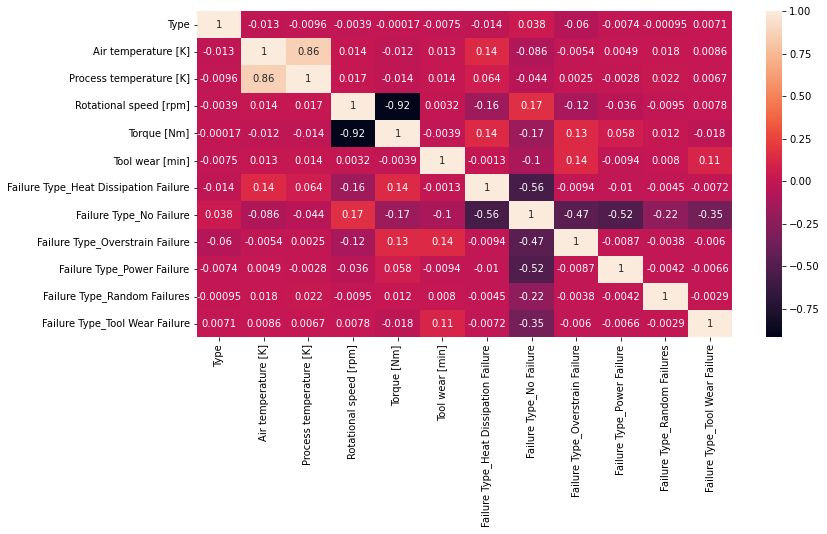

In [99]:
plt.figure(figsize=(12, 6))

sns.heatmap(df_dummies_final.corr('spearman'), annot=True);

Voltando o conjunto de dados para sua totalidade, conseguimos perceber uma alteração na correlação das colunas com os tipos de falha, o que indica que talvez seja mais difícil diferenciar as falhas diretamente.

## Construíndo Modelos

Para esse caso, a métrica que utilizaremos para definir o melhor modelo será a Precisão em relação a No Failure, uma vez que é melhor que o modelo erre os outros tipos de erro que dizer que o equipamento não vai ter erro e ele se danificar no meio do processo.

In [100]:
X = df_final.drop(columns = 'Failure Type')
y = df_final['Failure Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Criando Função para exibir as métricas de classificação

In [101]:
def exibir_metricas(y_train, y_pred_train, y_test, y_pred_test):
    print("\nMétricas de avaliação de treino:")

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    print("\n# =======================================================\n")

    print("\nMétricas de avaliação de teste:")

    print(confusion_matrix(y_test, y_pred_test))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

### Regressão Logística

In [102]:
lista_etapas_lr = [("std_scaler", StandardScaler()), 
                   ("poly", PolynomialFeatures()),
                   ("lr", LogisticRegression(max_iter = 1000))]

pipeline_lr = Pipeline(lista_etapas_lr)

cv_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_lr = make_scorer(precision_score, pos_label = 'No Failure', average = 'weighted')

param_grid_lr = {"lr__solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 "poly__degree": range(2,4)}

#verbose=10 pra muitas combinações, os prints vão pro terminal
rando_lr = RandomizedSearchCV(estimator = pipeline_lr, 
                              param_distributions = param_grid_lr,
                              scoring = scoring_lr,
                              cv = cv_lr,
                              verbose = 10,
                              n_iter = 10)

rando_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START lr__solver=saga, poly__degree=3............................
[CV 1/5; 1/10] END lr__solver=saga, poly__degree=3;, score=0.970 total time=  12.0s
[CV 2/5; 1/10] START lr__solver=saga, poly__degree=3............................
[CV 2/5; 1/10] END lr__solver=saga, poly__degree=3;, score=0.970 total time=  11.9s
[CV 3/5; 1/10] START lr__solver=saga, poly__degree=3............................
[CV 3/5; 1/10] END lr__solver=saga, poly__degree=3;, score=0.962 total time=  12.0s
[CV 4/5; 1/10] START lr__solver=saga, poly__degree=3............................
[CV 4/5; 1/10] END lr__solver=saga, poly__degree=3;, score=0.974 total time=  12.0s
[CV 5/5; 1/10] START lr__solver=saga, poly__degree=3............................
[CV 5/5; 1/10] END lr__solver=saga, poly__degree=3;, score=0.971 total time=  12.0s
[CV 1/5; 2/10] START lr__solver=liblinear, poly__degree=3.......................
[CV 1/5; 2/10] END lr__solver=lib

[CV 4/5; 10/10] END lr__solver=newton-cholesky, poly__degree=2;, score=0.976 total time=   0.0s
[CV 5/5; 10/10] START lr__solver=newton-cholesky, poly__degree=2................
[CV 5/5; 10/10] END lr__solver=newton-cholesky, poly__degree=2;, score=0.975 total time=   0.0s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('poly', PolynomialFeatures()),
                                             ('lr',
                                              LogisticRegression(max_iter=1000))]),
                   param_distributions={'lr__solver': ['lbfgs', 'liblinear',
                                                       'newton-cg',
                                                       'newton-cholesky', 'sag',
                                                       'saga'],
                                        'poly__degree': range(2, 4)},
                   scoring=make_scorer(precision_score, pos_label=No Failure, average=weighted),
                   verbose=10)

In [103]:
print('Melhores Parâmetros:')
print(rando_lr.best_params_)
print('Melhor Métrica Média:')
print(rando_lr.best_score_)

Melhores Parâmetros:
{'poly__degree': 3, 'lr__solver': 'lbfgs'}
Melhor Métrica Média:
0.9772185680568123



Métricas de avaliação de treino:


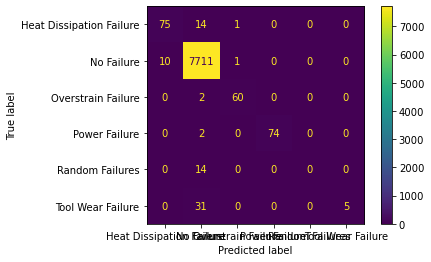

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.88      0.83      0.86        90
              No Failure       0.99      1.00      1.00      7722
      Overstrain Failure       0.97      0.97      0.97        62
           Power Failure       1.00      0.97      0.99        76
         Random Failures       0.00      0.00      0.00        14
       Tool Wear Failure       1.00      0.14      0.24        36

                accuracy                           0.99      8000
               macro avg       0.81      0.65      0.68      8000
            weighted avg       0.99      0.99      0.99      8000


# =======================================================


Métricas de avaliação de teste:
[[  15    7    0    0    0    0]
 [   5 1922    0    1    0    2]
 [   0    4   12    0    0    0]
 [   0    3    1   15    0    0]
 [   0    4    0    0    0    0]
 [   0    8    1    0    0    0]]


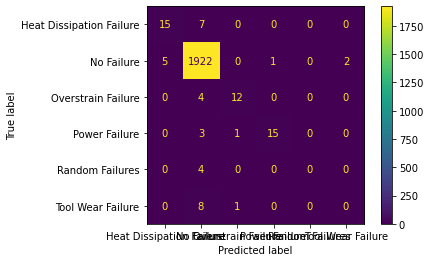

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.75      0.68      0.71        22
              No Failure       0.99      1.00      0.99      1930
      Overstrain Failure       0.86      0.75      0.80        16
           Power Failure       0.94      0.79      0.86        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.98      2000
               macro avg       0.59      0.54      0.56      2000
            weighted avg       0.98      0.98      0.98      2000



In [104]:
y_pred_test = rando_lr.predict(X_test)
y_pred_train = rando_lr.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Utilizando métodos de classificação

### KNN

In [105]:
lista_etapas_knn = [('scaler', StandardScaler()), 
                    ('knn', KNeighborsClassifier())]
pipeline_knn = Pipeline(lista_etapas_knn)

cv_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

scoring_knn = make_scorer(precision_score, pos_label = 'No Failure', average = 'weighted')

param_grid_knn = {"knn__weights" : ["distance", "uniform"],
                  "knn__metric" : ["manhattan", "euclidean", "minkowski"],
                  "knn__n_neighbors" : range(3, 20)}

grid_knn = GridSearchCV(estimator = pipeline_knn, 
                        param_grid = param_grid_knn,
                        scoring = scoring_knn,
                        cv = cv_knn,
                        verbose = 10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 102 candidates, totalling 1020 fits
[CV 1/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 1/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.967 total time=   0.0s
[CV 2/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 2/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 3/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 3/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.952 total time=   0.0s
[CV 4/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 4/10; 1/102] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance;, score=0.975 total time=   0.0s
[CV 5/10; 1/102] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 5/10; 1/102] EN

[CV 1/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.969 total time=   0.0s
[CV 2/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 2/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.961 total time=   0.0s
[CV 3/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 3/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.957 total time=   0.0s
[CV 4/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 4/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.976 total time=   0.0s
[CV 5/10; 5/102] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 5/10; 5/102] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 6/10; 5/102] START knn__metric=manhattan, knn__n_

[CV 1/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 2/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 2/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.960 total time=   0.0s
[CV 3/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 3/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.957 total time=   0.0s
[CV 4/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 4/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.975 total time=   0.0s
[CV 5/10; 9/102] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 5/10; 9/102] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 6/10; 9/102] START knn__metric=manhattan, knn__n_

[CV 1/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 2/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 2/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 3/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 3/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.957 total time=   0.0s
[CV 4/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 4/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.967 total time=   0.0s
[CV 5/10; 13/102] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 5/10; 13/102] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 6/10; 13/102] START knn__metric=manhatta

[CV 8/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.953 total time=   0.0s
[CV 9/10; 17/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 9/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 10/10; 17/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 10/10; 17/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.969 total time=   0.0s
[CV 1/10; 18/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 1/10; 18/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.968 total time=   0.0s
[CV 2/10; 18/102] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 2/10; 18/102] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.964 total time=   0.0s
[CV 3/10; 18/102] START knn__metric=m

[CV 3/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.948 total time=   0.0s
[CV 4/10; 22/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 4/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.953 total time=   0.0s
[CV 5/10; 22/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 5/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.963 total time=   0.0s
[CV 6/10; 22/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 6/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.964 total time=   0.0s
[CV 7/10; 22/102] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 7/10; 22/102] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.958 total time=   0.0s
[CV 8/10; 22/102] START knn__metric=manhatta

[CV 5/10; 26/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.963 total time=   0.0s
[CV 6/10; 26/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 6/10; 26/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.966 total time=   0.0s
[CV 7/10; 26/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 7/10; 26/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.956 total time=   0.0s
[CV 8/10; 26/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 8/10; 26/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.963 total time=   0.0s
[CV 9/10; 26/102] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 9/10; 26/102] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.961 total time=   0.0s
[CV 10/10; 26/102] START knn__metric=manhatt

[CV 6/10; 30/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.967 total time=   0.0s
[CV 7/10; 30/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 7/10; 30/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.955 total time=   0.0s
[CV 8/10; 30/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 8/10; 30/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.951 total time=   0.0s
[CV 9/10; 30/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 9/10; 30/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.963 total time=   0.0s
[CV 10/10; 30/102] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 10/10; 30/102] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.965 total time=   0.0s
[CV 1/10; 31/102] START knn__metric=manhat

[CV 8/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.951 total time=   0.0s
[CV 9/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 9/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.963 total time=   0.0s
[CV 10/10; 34/102] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 10/10; 34/102] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.965 total time=   0.0s
[CV 1/10; 35/102] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 1/10; 35/102] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 2/10; 35/102] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 2/10; 35/102] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=0.965 total time=   0.0s
[CV 3/10; 35/102] START knn__metric=euclid

[CV 10/10; 38/102] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.965 total time=   0.0s
[CV 1/10; 39/102] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance
[CV 1/10; 39/102] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 2/10; 39/102] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance
[CV 2/10; 39/102] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=0.960 total time=   0.0s
[CV 3/10; 39/102] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance
[CV 3/10; 39/102] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=0.959 total time=   0.0s
[CV 4/10; 39/102] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance
[CV 4/10; 39/102] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 5/10; 39/102] START knn__metric=euclidea

[CV 3/10; 43/102] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.959 total time=   0.0s
[CV 4/10; 43/102] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance
[CV 4/10; 43/102] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.968 total time=   0.0s
[CV 5/10; 43/102] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance
[CV 5/10; 43/102] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 6/10; 43/102] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance
[CV 6/10; 43/102] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.961 total time=   0.0s
[CV 7/10; 43/102] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance
[CV 7/10; 43/102] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance;, score=0.959 total time=   0.0s
[CV 8/10; 43/102] START knn__metric=euclidea

[CV 5/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 6/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 6/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 7/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 7/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.954 total time=   0.0s
[CV 8/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 8/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.951 total time=   0.0s
[CV 9/10; 47/102] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 9/10; 47/102] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 10/10; 47/102] START knn__metric=euclide

[CV 6/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.961 total time=   0.0s
[CV 7/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 7/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.955 total time=   0.0s
[CV 8/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 8/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.963 total time=   0.0s
[CV 9/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 9/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 10/10; 51/102] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 10/10; 51/102] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 1/10; 52/102] START knn__metr

[CV 5/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.952 total time=   0.0s
[CV 6/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 6/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.968 total time=   0.0s
[CV 7/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 7/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.955 total time=   0.0s
[CV 8/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 8/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.950 total time=   0.0s
[CV 9/10; 55/102] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 9/10; 55/102] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 10/10; 55/102] START knn__metri

[CV 1/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.958 total time=   0.0s
[CV 2/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 2/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.954 total time=   0.0s
[CV 3/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 3/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.948 total time=   0.0s
[CV 4/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 4/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.958 total time=   0.0s
[CV 5/10; 60/102] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform
[CV 5/10; 60/102] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.951 total time=   0.0s
[CV 6/10; 60/102] START knn__metric=euclidea

[CV 5/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.940 total time=   0.0s
[CV 6/10; 64/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform
[CV 6/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.966 total time=   0.0s
[CV 7/10; 64/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform
[CV 7/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.953 total time=   0.0s
[CV 8/10; 64/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform
[CV 8/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.948 total time=   0.0s
[CV 9/10; 64/102] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform
[CV 9/10; 64/102] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=uniform;, score=0.949 total time=   0.0s
[CV 10/10; 64/102] START knn__metric=euclide

[CV 7/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.953 total time=   0.0s
[CV 8/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 8/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.948 total time=   0.0s
[CV 9/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 9/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.961 total time=   0.0s
[CV 10/10; 68/102] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform
[CV 10/10; 68/102] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=uniform;, score=0.965 total time=   0.0s
[CV 1/10; 69/102] START knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance
[CV 1/10; 69/102] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 2/10; 69/102] START knn__metric=minkow

[CV 10/10; 72/102] END knn__metric=minkowski, knn__n_neighbors=4, knn__weights=uniform;, score=0.965 total time=   0.0s
[CV 1/10; 73/102] START knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance
[CV 1/10; 73/102] END knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance;, score=0.966 total time=   0.0s
[CV 2/10; 73/102] START knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance
[CV 2/10; 73/102] END knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance;, score=0.960 total time=   0.0s
[CV 3/10; 73/102] START knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance
[CV 3/10; 73/102] END knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance;, score=0.959 total time=   0.0s
[CV 4/10; 73/102] START knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance
[CV 4/10; 73/102] END knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance;, score=0.971 total time=   0.0s
[CV 5/10; 73/102] START knn__metric=minkowsk

[CV 1/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.969 total time=   0.0s
[CV 2/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 2/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.956 total time=   0.0s
[CV 3/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 3/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.959 total time=   0.0s
[CV 4/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 4/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.968 total time=   0.0s
[CV 5/10; 77/102] START knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance
[CV 5/10; 77/102] END knn__metric=minkowski, knn__n_neighbors=7, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 6/10; 77/102] START knn__metric=minkowsk

[CV 1/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.969 total time=   0.0s
[CV 2/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 2/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.955 total time=   0.0s
[CV 3/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 3/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.958 total time=   0.0s
[CV 4/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 4/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.967 total time=   0.0s
[CV 5/10; 81/102] START knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance
[CV 5/10; 81/102] END knn__metric=minkowski, knn__n_neighbors=9, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 6/10; 81/102] START knn__metric=minkowsk

[CV 1/10; 85/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance;, score=0.954 total time=   0.0s
[CV 2/10; 85/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance
[CV 2/10; 85/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance;, score=0.954 total time=   0.0s
[CV 3/10; 85/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance
[CV 3/10; 85/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance;, score=0.958 total time=   0.0s
[CV 4/10; 85/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance
[CV 4/10; 85/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance;, score=0.965 total time=   0.0s
[CV 5/10; 85/102] START knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance
[CV 5/10; 85/102] END knn__metric=minkowski, knn__n_neighbors=11, knn__weights=distance;, score=0.952 total time=   0.0s
[CV 6/10; 85/102] START knn__metric

[CV 1/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.952 total time=   0.0s
[CV 2/10; 89/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance
[CV 2/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.954 total time=   0.0s
[CV 3/10; 89/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance
[CV 3/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.959 total time=   0.0s
[CV 4/10; 89/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance
[CV 4/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.960 total time=   0.0s
[CV 5/10; 89/102] START knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance
[CV 5/10; 89/102] END knn__metric=minkowski, knn__n_neighbors=13, knn__weights=distance;, score=0.952 total time=   0.0s
[CV 6/10; 89/102] START knn__metric

[CV 6/10; 93/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance;, score=0.968 total time=   0.0s
[CV 7/10; 93/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance
[CV 7/10; 93/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance;, score=0.952 total time=   0.0s
[CV 8/10; 93/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance
[CV 8/10; 93/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance;, score=0.951 total time=   0.0s
[CV 9/10; 93/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance
[CV 9/10; 93/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance;, score=0.964 total time=   0.0s
[CV 10/10; 93/102] START knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance
[CV 10/10; 93/102] END knn__metric=minkowski, knn__n_neighbors=15, knn__weights=distance;, score=0.967 total time=   0.0s
[CV 1/10; 94/102] START knn__metr

[CV 1/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.945 total time=   0.0s
[CV 2/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 2/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.951 total time=   0.0s
[CV 3/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 3/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 4/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.958 total time=   0.0s
[CV 5/10; 98/102] START knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform
[CV 5/10; 98/102] END knn__metric=minkowski, knn__n_neighbors=17, knn__weights=uniform;, score=0.940 total time=   0.0s
[CV 6/10; 98/102] START knn__metric=minkowsk

[CV 3/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.932 total time=   0.0s
[CV 4/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 4/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.946 total time=   0.0s
[CV 5/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 5/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.940 total time=   0.0s
[CV 6/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 6/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.966 total time=   0.0s
[CV 7/10; 102/102] START knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform
[CV 7/10; 102/102] END knn__metric=minkowski, knn__n_neighbors=19, knn__weights=uniform;, score=0.953 total time=   0.0s
[CV 8/10; 102/102] START knn__metri

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean', 'minkowski'],
                         'knn__n_neighbors': range(3, 20),
                         'knn__weights': ['distance', 'uniform']},
             scoring=make_scorer(precision_score, pos_label=No Failure, average=weighted),
             verbose=10)

In [106]:
print('Melhores Parâmetros:')
print(grid_knn.best_params_)
print('Melhor Métrica Média:')
print(grid_knn.best_score_)

Melhores Parâmetros:
{'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Melhor Métrica Média:
0.9670975172266333



Métricas de avaliação de treino:


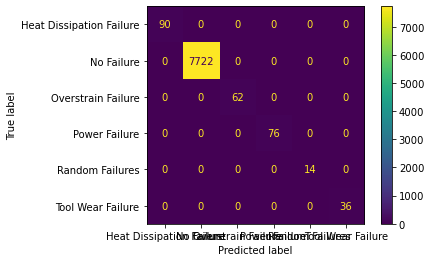

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        90
              No Failure       1.00      1.00      1.00      7722
      Overstrain Failure       1.00      1.00      1.00        62
           Power Failure       1.00      1.00      1.00        76
         Random Failures       1.00      1.00      1.00        14
       Tool Wear Failure       1.00      1.00      1.00        36

                accuracy                           1.00      8000
               macro avg       1.00      1.00      1.00      8000
            weighted avg       1.00      1.00      1.00      8000


# =======================================================


Métricas de avaliação de teste:
[[   8   14    0    0    0    0]
 [   3 1923    0    2    0    2]
 [   0    9    7    0    0    0]
 [   0   14    0    5    0    0]
 [   0    4    0    0    0    0]
 [   0    9    0    0    0    0]]


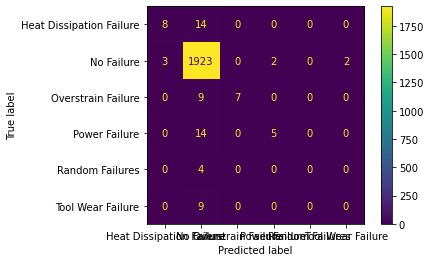

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.73      0.36      0.48        22
              No Failure       0.97      1.00      0.99      1930
      Overstrain Failure       1.00      0.44      0.61        16
           Power Failure       0.71      0.26      0.38        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.97      2000
               macro avg       0.57      0.34      0.41      2000
            weighted avg       0.96      0.97      0.96      2000



In [107]:
y_pred_test = grid_knn.predict(X_test)
y_pred_train = grid_knn.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

### Árvore de Decisões

In [108]:
lista_etapas_dt = [('scaler', StandardScaler()), 
                   ("dt", DecisionTreeClassifier(random_state=42))]
pipeline_dt = Pipeline(lista_etapas_dt)

cv_dt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_dt = make_scorer(precision_score, pos_label = 'No Failure', average = 'weighted')

params_grid_dt = {"dt__criterion" : ["gini", "entropy"],
                  "dt__splitter" : ["best", "random"],
                  "dt__max_depth" : range(2, 11)} 

grid_dt = GridSearchCV(estimator = pipeline_dt, 
                        param_grid = params_grid_dt,
                        scoring = scoring_dt,
                        cv = cv_dt,
                        verbose=10)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 1/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.947 total time=   0.0s
[CV 2/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 2/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.946 total time=   0.0s
[CV 3/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 3/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.945 total time=   0.0s
[CV 4/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 4/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.948 total time=   0.0s
[CV 5/5; 1/36] START dt__criterion=gini, dt__max_depth=2, dt__splitter=best.....
[CV 5/5; 1/36] END dt__criterion=gini, dt__max_depth=2, dt__splitter=best;, score=0.944 total time=   0.0

[CV 1/5; 11/36] END dt__criterion=gini, dt__max_depth=7, dt__splitter=best;, score=0.970 total time=   0.0s
[CV 2/5; 11/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=best....
[CV 2/5; 11/36] END dt__criterion=gini, dt__max_depth=7, dt__splitter=best;, score=0.976 total time=   0.0s
[CV 3/5; 11/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=best....
[CV 3/5; 11/36] END dt__criterion=gini, dt__max_depth=7, dt__splitter=best;, score=0.971 total time=   0.0s
[CV 4/5; 11/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=best....
[CV 4/5; 11/36] END dt__criterion=gini, dt__max_depth=7, dt__splitter=best;, score=0.971 total time=   0.0s
[CV 5/5; 11/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=best....
[CV 5/5; 11/36] END dt__criterion=gini, dt__max_depth=7, dt__splitter=best;, score=0.974 total time=   0.0s
[CV 1/5; 12/36] START dt__criterion=gini, dt__max_depth=7, dt__splitter=random..
[CV 1/5; 12/36] END dt__criterion=gini, dt__max_depth=7

[CV 2/5; 20/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=random;, score=0.940 total time=   0.0s
[CV 3/5; 20/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=random
[CV 3/5; 20/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=random;, score=0.942 total time=   0.0s
[CV 4/5; 20/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=random
[CV 4/5; 20/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=random;, score=0.942 total time=   0.0s
[CV 5/5; 20/36] START dt__criterion=entropy, dt__max_depth=2, dt__splitter=random
[CV 5/5; 20/36] END dt__criterion=entropy, dt__max_depth=2, dt__splitter=random;, score=0.941 total time=   0.0s
[CV 1/5; 21/36] START dt__criterion=entropy, dt__max_depth=3, dt__splitter=best.
[CV 1/5; 21/36] END dt__criterion=entropy, dt__max_depth=3, dt__splitter=best;, score=0.945 total time=   0.0s
[CV 2/5; 21/36] START dt__criterion=entropy, dt__max_depth=3, dt__splitter=best.
[CV 2/5; 21/36] END dt__crite

[CV 2/5; 30/36] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=0.961 total time=   0.0s
[CV 3/5; 30/36] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 3/5; 30/36] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=0.959 total time=   0.0s
[CV 4/5; 30/36] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 4/5; 30/36] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=0.961 total time=   0.0s
[CV 5/5; 30/36] START dt__criterion=entropy, dt__max_depth=7, dt__splitter=random
[CV 5/5; 30/36] END dt__criterion=entropy, dt__max_depth=7, dt__splitter=random;, score=0.957 total time=   0.0s
[CV 1/5; 31/36] START dt__criterion=entropy, dt__max_depth=8, dt__splitter=best.
[CV 1/5; 31/36] END dt__criterion=entropy, dt__max_depth=8, dt__splitter=best;, score=0.968 total time=   0.0s
[CV 2/5; 31/36] START dt__criterion=entropy, dt__max_depth=8, dt__splitter=best.
[CV 2/5; 31/36] END dt__crite

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(2, 11),
                         'dt__splitter': ['best', 'random']},
             scoring=make_scorer(precision_score, pos_label=No Failure, average=weighted),
             verbose=10)

In [109]:
print('Melhores Parâmetros:')
print(grid_dt.best_params_)
print('Melhor Métrica Média:')
print(grid_dt.best_score_)

Melhores Parâmetros:
{'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__splitter': 'best'}
Melhor Métrica Média:
0.9770112881429812



Métricas de avaliação de treino:


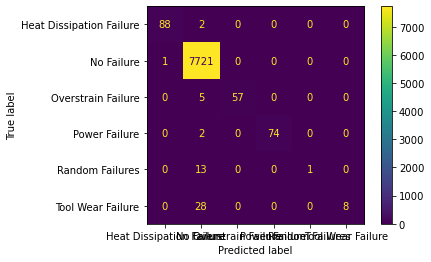

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.99      0.98      0.98        90
              No Failure       0.99      1.00      1.00      7722
      Overstrain Failure       1.00      0.92      0.96        62
           Power Failure       1.00      0.97      0.99        76
         Random Failures       1.00      0.07      0.13        14
       Tool Wear Failure       1.00      0.22      0.36        36

                accuracy                           0.99      8000
               macro avg       1.00      0.69      0.74      8000
            weighted avg       0.99      0.99      0.99      8000


# =======================================================


Métricas de avaliação de teste:
[[  18    4    0    0    0    0]
 [   1 1926    3    0    0    0]
 [   1    7    8    0    0    0]
 [   0    3    0   16    0    0]
 [   1    3    0    0    0    0]
 [   0    7    1    0    0    1]]


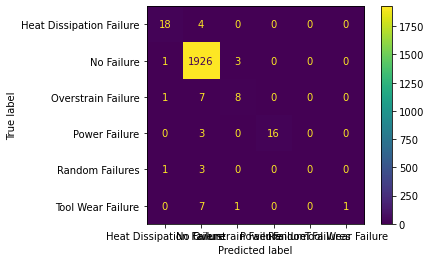

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.86      0.82      0.84        22
              No Failure       0.99      1.00      0.99      1930
      Overstrain Failure       0.67      0.50      0.57        16
           Power Failure       1.00      0.84      0.91        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       1.00      0.11      0.20         9

                accuracy                           0.98      2000
               macro avg       0.75      0.54      0.59      2000
            weighted avg       0.98      0.98      0.98      2000



In [110]:
y_pred_test = grid_dt.predict(X_test)
y_pred_train = grid_dt.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Utilizando métodos de Ensemble

### Random Forest

In [111]:
lista_etapas_rf = [("std_scaler", StandardScaler()), 
                   ("rf", RandomForestClassifier(n_jobs=-1))]

pipeline_rf = Pipeline(lista_etapas_rf)

cv_rf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


scoring_rf = make_scorer(precision_score, pos_label = 'No Failure', average = 'weighted')


param_grid_rf = {"rf__n_estimators" : range(100, 600, 100),
                 "rf__max_depth" : range(3, 6),
                 "rf__max_features" : ['sqrt', 'log2'],
                 "rf__criterion" : ['entropy', 'gini']}

grid_rf = GridSearchCV(estimator = pipeline_rf, 
                        param_grid = param_grid_rf,
                        scoring = scoring_rf,
                        cv = cv_rf,
                        verbose = 10)


grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 1/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.934 total time=   0.0s
[CV 2/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 2/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.944 total time=   0.0s
[CV 3/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 3/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.931 total time=   0.0s
[CV 4/10; 1/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 4/10; 1/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10

[CV 4/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.945 total time=   0.2s
[CV 5/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 5/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.941 total time=   0.2s
[CV 6/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 6/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.931 total time=   0.2s
[CV 7/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 7/10; 4/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400;, score=0.944 total time=   0.2s
[CV 8/10; 4/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=400
[CV 8/10; 4/60] END rf__crit

[CV 9/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.931 total time=   0.1s
[CV 10/10; 7/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200
[CV 10/10; 7/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=200;, score=0.941 total time=   0.1s
[CV 1/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 1/10; 8/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.934 total time=   0.2s
[CV 2/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 2/10; 8/60] END rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.944 total time=   0.2s
[CV 3/10; 8/60] START rf__criterion=entropy, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 3/10; 8/60] END rf__cr

[CV 4/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.946 total time=   0.0s
[CV 5/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 5/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.942 total time=   0.0s
[CV 6/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 6/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.945 total time=   0.0s
[CV 7/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 7/10; 11/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100;, score=0.946 total time=   0.0s
[CV 8/10; 11/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=100
[CV 8/10; 11/60] END

[CV 8/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.942 total time=   0.2s
[CV 9/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 9/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.946 total time=   0.2s
[CV 10/10; 14/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400
[CV 10/10; 14/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=400;, score=0.955 total time=   0.2s
[CV 1/10; 15/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500
[CV 1/10; 15/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500;, score=0.946 total time=   0.3s
[CV 2/10; 15/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500
[CV 2/10; 15/60] E

[CV 2/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.952 total time=   0.2s
[CV 3/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 3/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.942 total time=   0.2s
[CV 4/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 4/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.945 total time=   0.2s
[CV 5/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 5/10; 18/60] END rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300;, score=0.942 total time=   0.2s
[CV 6/10; 18/60] START rf__criterion=entropy, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=300
[CV 6/10; 18/60] END

[CV 6/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.959 total time=   0.0s
[CV 7/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 7/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.954 total time=   0.0s
[CV 8/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 8/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.953 total time=   0.0s
[CV 9/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 9/10; 21/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100;, score=0.954 total time=   0.0s
[CV 10/10; 21/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100
[CV 10/10; 21/60] E

[CV 10/10; 24/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=400;, score=0.954 total time=   0.2s
[CV 1/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 1/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.948 total time=   0.3s
[CV 2/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 2/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.954 total time=   0.3s
[CV 3/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 3/10; 25/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500;, score=0.956 total time=   0.3s
[CV 4/10; 25/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=500
[CV 4/10; 25/60] EN

[CV 4/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.947 total time=   0.2s
[CV 5/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 5/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.944 total time=   0.2s
[CV 6/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 6/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.954 total time=   0.2s
[CV 7/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 7/10; 28/60] END rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300;, score=0.966 total time=   0.2s
[CV 8/10; 28/60] START rf__criterion=entropy, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=300
[CV 8/10; 28/60] END

[CV 9/10; 31/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.943 total time=   0.0s
[CV 10/10; 31/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100
[CV 10/10; 31/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100;, score=0.943 total time=   0.0s
[CV 1/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 1/10; 32/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200;, score=0.946 total time=   0.1s
[CV 2/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 2/10; 32/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200;, score=0.948 total time=   0.1s
[CV 3/10; 32/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=200
[CV 3/10; 32/60] END rf__criterion=gini, r

[CV 4/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.946 total time=   0.3s
[CV 5/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 5/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.942 total time=   0.3s
[CV 6/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 6/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.949 total time=   0.3s
[CV 7/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 7/10; 35/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500;, score=0.945 total time=   0.3s
[CV 8/10; 35/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=500
[CV 8/10; 35/60] END rf__criterion=gini, rf_

[CV 9/10; 38/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.945 total time=   0.2s
[CV 10/10; 38/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300
[CV 10/10; 38/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=300;, score=0.943 total time=   0.2s
[CV 1/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 1/10; 39/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400;, score=0.946 total time=   0.2s
[CV 2/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 2/10; 39/60] END rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400;, score=0.948 total time=   0.2s
[CV 3/10; 39/60] START rf__criterion=gini, rf__max_depth=3, rf__max_features=log2, rf__n_estimators=400
[CV 3/10; 39/60] END rf__criterion=gini, r

[CV 5/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.942 total time=   0.1s
[CV 6/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 6/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.948 total time=   0.1s
[CV 7/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 7/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.947 total time=   0.1s
[CV 8/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 8/10; 42/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200;, score=0.947 total time=   0.1s
[CV 9/10; 42/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=200
[CV 9/10; 42/60] END rf__criterion=gini, rf_

[CV 10/10; 45/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=sqrt, rf__n_estimators=500;, score=0.943 total time=   0.3s
[CV 1/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 1/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.947 total time=   0.0s
[CV 2/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 2/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.949 total time=   0.0s
[CV 3/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 3/10; 46/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100;, score=0.948 total time=   0.0s
[CV 4/10; 46/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=100
[CV 4/10; 46/60] END rf__criterion=gini, rf

[CV 5/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.943 total time=   0.2s
[CV 6/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 6/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.948 total time=   0.2s
[CV 7/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 7/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.947 total time=   0.2s
[CV 8/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 8/10; 49/60] END rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400;, score=0.947 total time=   0.2s
[CV 9/10; 49/60] START rf__criterion=gini, rf__max_depth=4, rf__max_features=log2, rf__n_estimators=400
[CV 9/10; 49/60] END rf__criterion=gini, rf_

[CV 10/10; 52/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=200;, score=0.943 total time=   0.1s
[CV 1/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 1/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.948 total time=   0.2s
[CV 2/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 2/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.949 total time=   0.2s
[CV 3/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 3/10; 53/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300;, score=0.948 total time=   0.2s
[CV 4/10; 53/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=300
[CV 4/10; 53/60] END rf__criterion=gini, rf

[CV 6/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.949 total time=   0.0s
[CV 7/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 7/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.958 total time=   0.0s
[CV 8/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 8/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.948 total time=   0.0s
[CV 9/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 9/10; 56/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100;, score=0.946 total time=   0.0s
[CV 10/10; 56/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=100
[CV 10/10; 56/60] END rf__criterion=gini, r

[CV 1/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.949 total time=   0.3s
[CV 2/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 2/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.954 total time=   0.3s
[CV 3/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 3/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.948 total time=   0.3s
[CV 4/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 4/10; 60/60] END rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500;, score=0.947 total time=   0.3s
[CV 5/10; 60/60] START rf__criterion=gini, rf__max_depth=5, rf__max_features=log2, rf__n_estimators=500
[CV 5/10; 60/60] END rf__criterion=gini, rf_

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rf__criterion': ['entropy', 'gini'],
                         'rf__max_depth': range(3, 6),
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__n_estimators': range(100, 600, 100)},
             scoring=make_scorer(precision_score, pos_label=No Failure, average=weighted),
             verbose=10)

In [112]:
print('Melhores Parâmetros:')
print(grid_rf.best_params_)
print('Melhor Métrica Média:')
print(grid_rf.best_score_)

Melhores Parâmetros:
{'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__n_estimators': 200}
Melhor Métrica Média:
0.9538546175401088



Métricas de avaliação de treino:


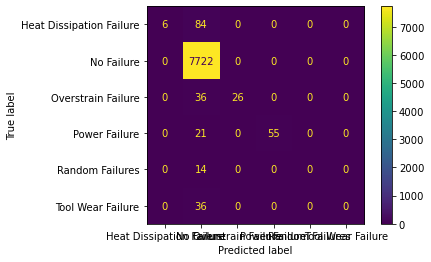

                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.07      0.12        90
              No Failure       0.98      1.00      0.99      7722
      Overstrain Failure       1.00      0.42      0.59        62
           Power Failure       1.00      0.72      0.84        76
         Random Failures       0.00      0.00      0.00        14
       Tool Wear Failure       0.00      0.00      0.00        36

                accuracy                           0.98      8000
               macro avg       0.66      0.37      0.42      8000
            weighted avg       0.97      0.98      0.97      8000


# =======================================================


Métricas de avaliação de teste:
[[   0   22    0    0    0    0]
 [   0 1928    0    2    0    0]
 [   0   13    3    0    0    0]
 [   0   10    0    9    0    0]
 [   0    4    0    0    0    0]
 [   0    9    0    0    0    0]]


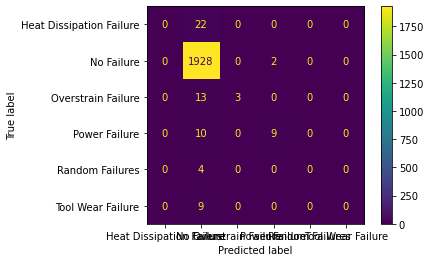

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.00      0.00      0.00        22
              No Failure       0.97      1.00      0.98      1930
      Overstrain Failure       1.00      0.19      0.32        16
           Power Failure       0.82      0.47      0.60        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.97      2000
               macro avg       0.46      0.28      0.32      2000
            weighted avg       0.95      0.97      0.96      2000



In [113]:
y_pred_test = grid_rf.predict(X_test)
y_pred_train = grid_rf.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

### AdaBoost

In [114]:
lista_etapas_ab = [("std_scaler", StandardScaler()), 
                   ("ab", AdaBoostClassifier())]

pipeline_ab = Pipeline(lista_etapas_ab)

cv_ab = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


scoring_ab = make_scorer(precision_score, pos_label = 'No Failure', average = 'weighted')


param_grid_ab = {"ab__n_estimators" : range(25, 100, 10)}

grid_ab = GridSearchCV(estimator = pipeline_ab, 
                        param_grid = param_grid_ab,
                        scoring = scoring_ab,
                        cv = cv_ab,
                        verbose = 10)


grid_ab.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START ab__n_estimators=25........................................
[CV 1/10; 1/8] END .........ab__n_estimators=25;, score=0.899 total time=   0.1s
[CV 2/10; 1/8] START ab__n_estimators=25........................................
[CV 2/10; 1/8] END .........ab__n_estimators=25;, score=0.917 total time=   0.1s
[CV 3/10; 1/8] START ab__n_estimators=25........................................
[CV 3/10; 1/8] END .........ab__n_estimators=25;, score=0.853 total time=   0.1s
[CV 4/10; 1/8] START ab__n_estimators=25........................................
[CV 4/10; 1/8] END .........ab__n_estimators=25;, score=0.885 total time=   0.1s
[CV 5/10; 1/8] START ab__n_estimators=25........................................
[CV 5/10; 1/8] END .........ab__n_estimators=25;, score=0.937 total time=   0.1s
[CV 6/10; 1/8] START ab__n_estimators=25........................................
[CV 6/10; 1/8] END .........ab__n_estimators=25;

[CV 1/10; 6/8] END .........ab__n_estimators=75;, score=0.899 total time=   0.5s
[CV 2/10; 6/8] START ab__n_estimators=75........................................
[CV 2/10; 6/8] END .........ab__n_estimators=75;, score=0.913 total time=   0.5s
[CV 3/10; 6/8] START ab__n_estimators=75........................................
[CV 3/10; 6/8] END .........ab__n_estimators=75;, score=0.906 total time=   0.5s
[CV 4/10; 6/8] START ab__n_estimators=75........................................
[CV 4/10; 6/8] END .........ab__n_estimators=75;, score=0.888 total time=   0.5s
[CV 5/10; 6/8] START ab__n_estimators=75........................................
[CV 5/10; 6/8] END .........ab__n_estimators=75;, score=0.937 total time=   0.5s
[CV 6/10; 6/8] START ab__n_estimators=75........................................
[CV 6/10; 6/8] END .........ab__n_estimators=75;, score=0.871 total time=   0.5s
[CV 7/10; 6/8] START ab__n_estimators=75........................................
[CV 7/10; 6/8] END .........

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('ab', AdaBoostClassifier())]),
             param_grid={'ab__n_estimators': range(25, 100, 10)},
             scoring=make_scorer(precision_score, pos_label=No Failure, average=weighted),
             verbose=10)

In [115]:
print('Melhores Parâmetros:')
print(grid_ab.best_params_)
print('Melhor Métrica Média:')
print(grid_ab.best_score_)

Melhores Parâmetros:
{'ab__n_estimators': 45}
Melhor Métrica Média:
0.8978605959225998



Métricas de avaliação de treino:


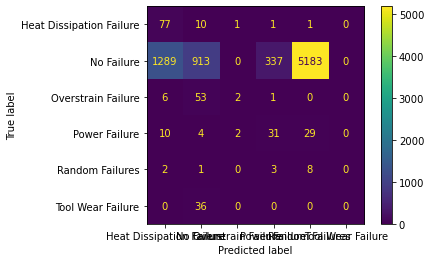

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.06      0.86      0.10        90
              No Failure       0.90      0.12      0.21      7722
      Overstrain Failure       0.40      0.03      0.06        62
           Power Failure       0.08      0.41      0.14        76
         Random Failures       0.00      0.57      0.00        14
       Tool Wear Failure       0.00      0.00      0.00        36

                accuracy                           0.13      8000
               macro avg       0.24      0.33      0.09      8000
            weighted avg       0.87      0.13      0.20      8000


# =======================================================


Métricas de avaliação de teste:
[[  19    2    0    0    1    0]
 [ 292  231    0   86 1321    0]
 [   3   12    1    0    0    0]
 [   3    1    0    8    7    0]
 [   1    0    0    0    3    0]
 [   0    9    0    0    0    0]]


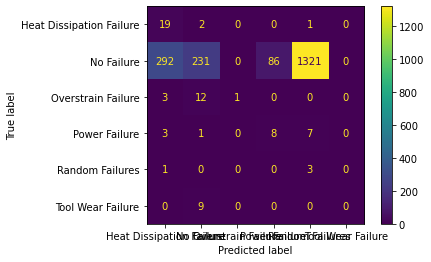

                          precision    recall  f1-score   support

Heat Dissipation Failure       0.06      0.86      0.11        22
              No Failure       0.91      0.12      0.21      1930
      Overstrain Failure       1.00      0.06      0.12        16
           Power Failure       0.09      0.42      0.14        19
         Random Failures       0.00      0.75      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.13      2000
               macro avg       0.34      0.37      0.10      2000
            weighted avg       0.88      0.13      0.21      2000



In [116]:
y_pred_test = grid_ab.predict(X_test)
y_pred_train = grid_ab.predict(X_train)

exibir_metricas(y_train, y_pred_train, y_test, y_pred_test)

## Resultado do Teste 1 Parte 2:

Como o conjunto de dados é muito desbalanceado, é fácil conseguir mais de 96% nas métricas. Por isso, iremos ranquear baseado no número de Falhas que foram consideradas Não Falhas:

- 1º - Árvore de Decisões - 0.99 - 24 Erros
- 2º - Regressão Logistica - 0.99 - 26 Erros
- 3º - Knn - 0.97 - 50 Erros
- 4º - Random Forest - 0.97 - 58 Erros
- 5º - AdaBoost - 0.91 - 24 Erros

Apesar de o AdaBoost dito que somente 24 dados com falhas são não falhas, ele disse que 1699 dados não falha são falhas. Apesar de não ser o que estamos focando, a confiabilidade dele é muito baixa, pois serão 1699 equipamentos que serão checados para nada por causa desse modelo.

# Conclusão

Como havia sido dito, os dados são extremamente desbalanceados, a separabilidades dos alvos não era algo trivial e, utilizando a biblioteca sklearn, as expectativas sobre os resultados deveriam ser reduzidas. Porém, apesar de tudo isso, os resultados foram surpreendentes.

Com os modelos criados, podemos ver que, os modelos performaram melhor quando tentamos adivinhar os problemas categoricamente, tanto com e sem os dados de falhas juntos no conjunto de dados, do que quando juntamos todos os problemas no mesmo rótulo e tentamos separar eles das não falhas.

Apesar de ter superado as expectativas, os modelos continuam precários e precisam passar por mais estudos para evitar ao máximo problemas nas indústrias e poder facilitar tanto o trabalho do setor de manutenção, quanto para reduzir o tempo em que a produção está parada e reduzir as perdas das indústrias.

Sendo assim, a conclusão final é de que, ainda existe muito estudo para ser feito para resolver esse problema. Mesmo superando as expectativas, os modelos não se encontram prontos para ser postos em prática.

# Próximos passos

- Procurar e utilizar métodos/bibliotecas para criar modelos que são capazes de trabalhar com dados extremamente desbalanceados a fim de ter uma melhora significativa.
- Caso não seja possível, procurar modos de fazer balanceamentos artificiais no dado a ponto de que seja possível trabalhar com a biblioteca utilizada neste trabalho.
- Tentar adquirir dados reais com alguma empresa que se disponha a disponibilizar os dados para uma análise mais profunda e verídica.